In [1]:
"""
FNB Customer Churn Prediction
Exploratory Data Analysis (EDA)

This script initialises the analytical environment used throughout the EDA.
"""

import numpy as np                      # Numerical operations and array-based calculations
import pandas as pd                     # Data loading, cleaning, and tabular analysis

import matplotlib.pyplot as plt          # Core plotting library for visual analysis
import seaborn as sns                   # Statistical plotting with cleaner defaults

from pathlib import Path                # Platform-independent file path handling


pd.set_option("display.max_columns", None)        # Show all columns when inspecting DataFrames
pd.set_option("display.width", 120)               # Prevent DataFrame output from wrapping
pd.set_option("display.max_colwidth", None)       # Display full text in each column
pd.options.display.float_format = "{:,.2f}".format  # Improve readability of financial values


sns.set_style("whitegrid")              # Apply a clean, professional visual theme
plt.rcParams["figure.figsize"] = (12, 6)  # Set default figure size for consistency
plt.rcParams["axes.titlesize"] = 14       # Standardise plot title size
plt.rcParams["axes.labelsize"] = 12       # Standardise axis label size
plt.rcParams["xtick.labelsize"] = 10      # Improve x-axis tick readability
plt.rcParams["ytick.labelsize"] = 10      # Improve y-axis tick readability


np.random.seed(42)                     # Ensure reproducible results for any random processes

In [2]:
# Load the FNB South African churn dataset
# This dataset has been contextualised for a single-bank (FNB) churn analysis

DATA_PATH = Path("Churn_Modelling_SA_FNB.csv")

print("Loading FNB South African Churn Dataset...")
df = pd.read_csv(DATA_PATH)

# Basic validation checks to confirm successful load
print(f"Loaded {len(df):,} customers with {df.shape[1]} features")
print(f"Overall churn rate: {df['Churned'].mean():.2%}")

Loading FNB South African Churn Dataset...
Loaded 10,000 customers with 43 features
Overall churn rate: 20.37%


## Section 3. Dataset Overview and Initial Sanity Checks

This section provides a high-level overview of the dataset before deeper exploratory analysis begins.  
The goal is to confirm that the data has been loaded correctly, understand its overall structure, and validate key business metrics.

At this stage, the focus is not on identifying patterns, but on answering foundational questions:
- How large is the dataset and how many features are available?
- How are features logically grouped from a banking perspective?
- What does the overall churn distribution look like?
- Do the financial values appear reasonable in a South African Rand context?
- Does the dataset reflect the intended single-bank scope for FNB?

Reviewing these elements early helps prevent downstream errors and ensures that all subsequent analysis is built on a sound and well-understood dataset.

In [3]:
# -----------------------------
# Quick dataset overview
# -----------------------------
# This section provides a high-level snapshot of the dataset
# to confirm structure, scale, and key business metrics before deep EDA.

print("\n" + "=" * 70)                                # Visual separator for readability
print("DATASET OVERVIEW")                             # Section title
print("=" * 70)                                       # Visual separator

print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns")  # Dataset size

# Feature group counts (based on dataset design)
print("\nFeature Categories:")                         # Logical grouping of features
print(f"  ID Columns: {3}")                            # RowNumber, CustomerId, Surname
print(f"  Demographics: {8}")                          # Age, Gender, Province, City, etc.
print(f"  Banking Info: {6}")                          # Bank, AccountType, Tenure, Credit
print(f"  Products: {11}")                             # Product ownership and flags
print(f"  Financial: {5}")                             # Balance, salary, wellness score
print(f"  Engagement: {8}")                            # Digital usage, visits, complaints
print(f"  Target: {1}")                                # Churned

# Financial summary statistics
print("\nFinancial Summary (ZAR):")                    # Currency context
print(f"  Average Balance: R{df['Balance_ZAR'].mean():,.2f}")          # Mean customer balance
print(f"  Average Annual Salary: R{df['AnnualSalary_ZAR'].mean():,.2f}")  # Mean annual income
print(f"  Average Monthly Salary: R{df['MonthlySalary_ZAR'].mean():,.2f}")  # Mean monthly income

# Churn distribution
print("\nChurn Distribution:")                         # Target variable breakdown
churn_counts = df["Churned"].value_counts()            # Count retained vs churned customers
print(f"  Retained: {churn_counts.get(0, 0):,} ({churn_counts.get(0, 0)/len(df)*100:.1f}%)")  # Non-churned
print(f"  Churned: {churn_counts.get(1, 0):,} ({churn_counts.get(1, 0)/len(df)*100:.1f}%)")    # Churned

# Banking distribution (single-bank validation)
print("\nBank Distribution:")                          # Confirm single-bank scope
print(df["Bank"].value_counts().to_string())           # Should show only FNB

# Geographic distribution
print("\nGeographic Distribution:")                    # Province-level customer spread
print(df["Province"].value_counts().to_string())       # Customer counts per province


DATASET OVERVIEW

Shape: 10,000 rows × 43 columns

Feature Categories:
  ID Columns: 3
  Demographics: 8
  Banking Info: 6
  Products: 11
  Financial: 5
  Engagement: 8
  Target: 1

Financial Summary (ZAR):
  Average Balance: R1,567,960.73
  Average Annual Salary: R2,051,849.92
  Average Monthly Salary: R170,987.49

Churn Distribution:
  Retained: 7,963 (79.6%)
  Churned: 2,037 (20.4%)

Bank Distribution:
Bank
FNB    10000

Geographic Distribution:
Province
Gauteng          2558
Western Cape     1468
North West       1022
Eastern Cape     1017
KwaZulu-Natal     988
Limpopo           894
Free State        859
Mpumalanga        598
Northern Cape     596


## Section 4. Data Quality Assessment

This section evaluates the overall quality and integrity of the dataset before proceeding to deeper exploratory analysis.  
The objective is to identify common data issues that can negatively affect analysis and modelling if left unaddressed.

Specifically, this section checks:
- The presence of missing values across all features.
- Whether each customer is represented by a single unique record.
- The consistency of data types across columns.
- The cardinality of categorical features to flag unusually high or low category counts.

Addressing these checks early ensures that subsequent insights are reliable and that the dataset is suitable for churn modelling.

In [4]:
# -----------------------------
# Section 4. Data quality checks
# -----------------------------
# This section validates the integrity of the dataset before deeper analysis.
# The goal is to identify missing values, duplicates, and potential schema issues early.

print("\n" + "=" * 70)                                  # Visual separator
print("DATA QUALITY CHECK")                             # Section title
print("=" * 70)

# Check for missing values across all columns
missing_values = df.isnull().sum()                      # Count nulls per column
if missing_values.sum() == 0:
    print("\nNo missing values detected")               # Ideal scenario for modelling
else:
    print("\nMissing values detected:")                 # Flag data quality issues
    print(missing_values[missing_values > 0])           # Display only affected columns

# Check for duplicate customers using CustomerId
duplicate_customers = df.duplicated(subset="CustomerId").sum()  # Count duplicate IDs
if duplicate_customers == 0:
    print("No duplicate Customer IDs found")             # Confirms one row per customer
else:
    print(f"{duplicate_customers} duplicate Customer IDs found")  # Requires investigation

# Review data types to confirm schema consistency
print("\nData type distribution:")                      # Schema-level validation
print(df.dtypes.value_counts())                         # Count of each dtype

# Review cardinality of categorical features
print("\nCategorical feature cardinality:")             # Helps detect high-cardinality issues
categorical_columns = df.select_dtypes(include="object").columns
for col in categorical_columns[:10]:                    # Limit output for readability
    print(f"{col}: {df[col].nunique()} unique values")  # Unique levels per categorical feature


DATA QUALITY CHECK

No missing values detected
No duplicate Customer IDs found

Data type distribution:
int64      23
object     16
float64     4
Name: count, dtype: int64

Categorical feature cardinality:
Surname: 2932 unique values
Gender: 2 unique values
Province: 9 unique values
City: 45 unique values
AreaType: 3 unique values
EducationLevel: 5 unique values
EmploymentType: 5 unique values
PreferredLanguage: 11 unique values
Bank: 1 unique values
AccountType: 5 unique values


## Section 5. Initial Churn Pattern Exploration

This section explores high-level churn patterns across key customer and banking dimensions.  
The objective is to identify where churn is concentrated before moving into deeper behavioural and statistical analysis.

At this stage, the analysis focuses on descriptive churn rates rather than causality.  
The results help answer early business questions such as:
- Which provinces show higher churn exposure?
- How does churn vary across credit risk segments?
- Does product depth reduce or increase churn risk?
- Are certain account types more vulnerable to churn?

These insights guide which segments deserve deeper investigation later in the EDA.

In [5]:
# -----------------------------
# Section 5. Churn pattern exploration
# -----------------------------
# This section calculates churn rates across key business dimensions
# to identify high-risk customer segments.

print("\n" + "=" * 70)                                  # Visual separator
print("CHURN PATTERNS")                                 # Section title
print("=" * 70)

# Churn by Province
print("\nChurn Rate by Province:")                      # Geographic churn segmentation
churn_by_province = df.groupby("Province")["Churned"].agg(["mean", "count"])
churn_by_province["churn_rate"] = (churn_by_province["mean"] * 100).round(2)
churn_by_province = churn_by_province.sort_values("churn_rate", ascending=False)
print(churn_by_province[["count", "churn_rate"]].to_string())

# Churn by Bank (single-bank validation)
print("\nChurn Rate by Bank:")                          # Confirms single-bank scope
churn_by_bank = df.groupby("Bank")["Churned"].agg(["mean", "count"])
churn_by_bank["churn_rate"] = (churn_by_bank["mean"] * 100).round(2)
churn_by_bank = churn_by_bank.sort_values("churn_rate", ascending=False)
print(churn_by_bank[["count", "churn_rate"]].to_string())

# Churn by Credit Rating
print("\nChurn Rate by Credit Rating:")                 # Credit risk segmentation
churn_by_credit = df.groupby("CreditRating")["Churned"].agg(["mean", "count"])
churn_by_credit["churn_rate"] = (churn_by_credit["mean"] * 100).round(2)
print(churn_by_credit[["count", "churn_rate"]].to_string())

# Churn by Number of Products
print("\nChurn Rate by Number of Products:")            # Product depth vs retention
churn_by_products = df.groupby("NumOfProducts")["Churned"].agg(["mean", "count"])
churn_by_products["churn_rate"] = (churn_by_products["mean"] * 100).round(2)
print(churn_by_products[["count", "churn_rate"]].to_string())

# Churn by Account Type
print("\nChurn Rate by Account Type:")                  # Account-level churn exposure
churn_by_account = df.groupby("AccountType")["Churned"].agg(["mean", "count"])
churn_by_account["churn_rate"] = (churn_by_account["mean"] * 100).round(2)
churn_by_account = churn_by_account.sort_values("churn_rate", ascending=False)
print(churn_by_account[["count", "churn_rate"]].to_string())


CHURN PATTERNS

Churn Rate by Province:
               count  churn_rate
Province                        
Limpopo          894       33.89
Eastern Cape    1017       32.06
Mpumalanga       598       30.94
Western Cape    1468       17.92
Free State       859       17.46
Northern Cape    596       16.78
North West      1022       15.95
Gauteng         2558       15.48
KwaZulu-Natal    988       15.28

Churn Rate by Bank:
      count  churn_rate
Bank                   
FNB   10000       20.37

Churn Rate by Credit Rating:
              count  churn_rate
CreditRating                   
Excellent       655       19.54
Fair           3331       20.56
Good           2428       18.62
Poor           2362       22.02
Very Good      1224       20.59

Churn Rate by Number of Products:
               count  churn_rate
NumOfProducts                   
1               5084       27.71
2               4590        7.58
3                266       82.71
4                 60      100.00

Churn Rate by A

## Section 6. Visualising Key Churn Insights

This section creates a small set of visuals that summarise the most important churn patterns identified so far.  
The objective is to translate summary tables into charts that are easier to interpret and communicate.

The plots focus on:
- Overall churn distribution.
- Geographic churn differences across provinces.
- Age distribution for retained vs churned customers.
- Credit score differences for retained vs churned customers.
- Balance differences using a log scale to handle skewness.

The output image is saved locally so it can be reused in documentation, reports, and the GitHub README.


GENERATING VISUALISATIONS

Saved visualisation as: fnb_churn_key_insights.png


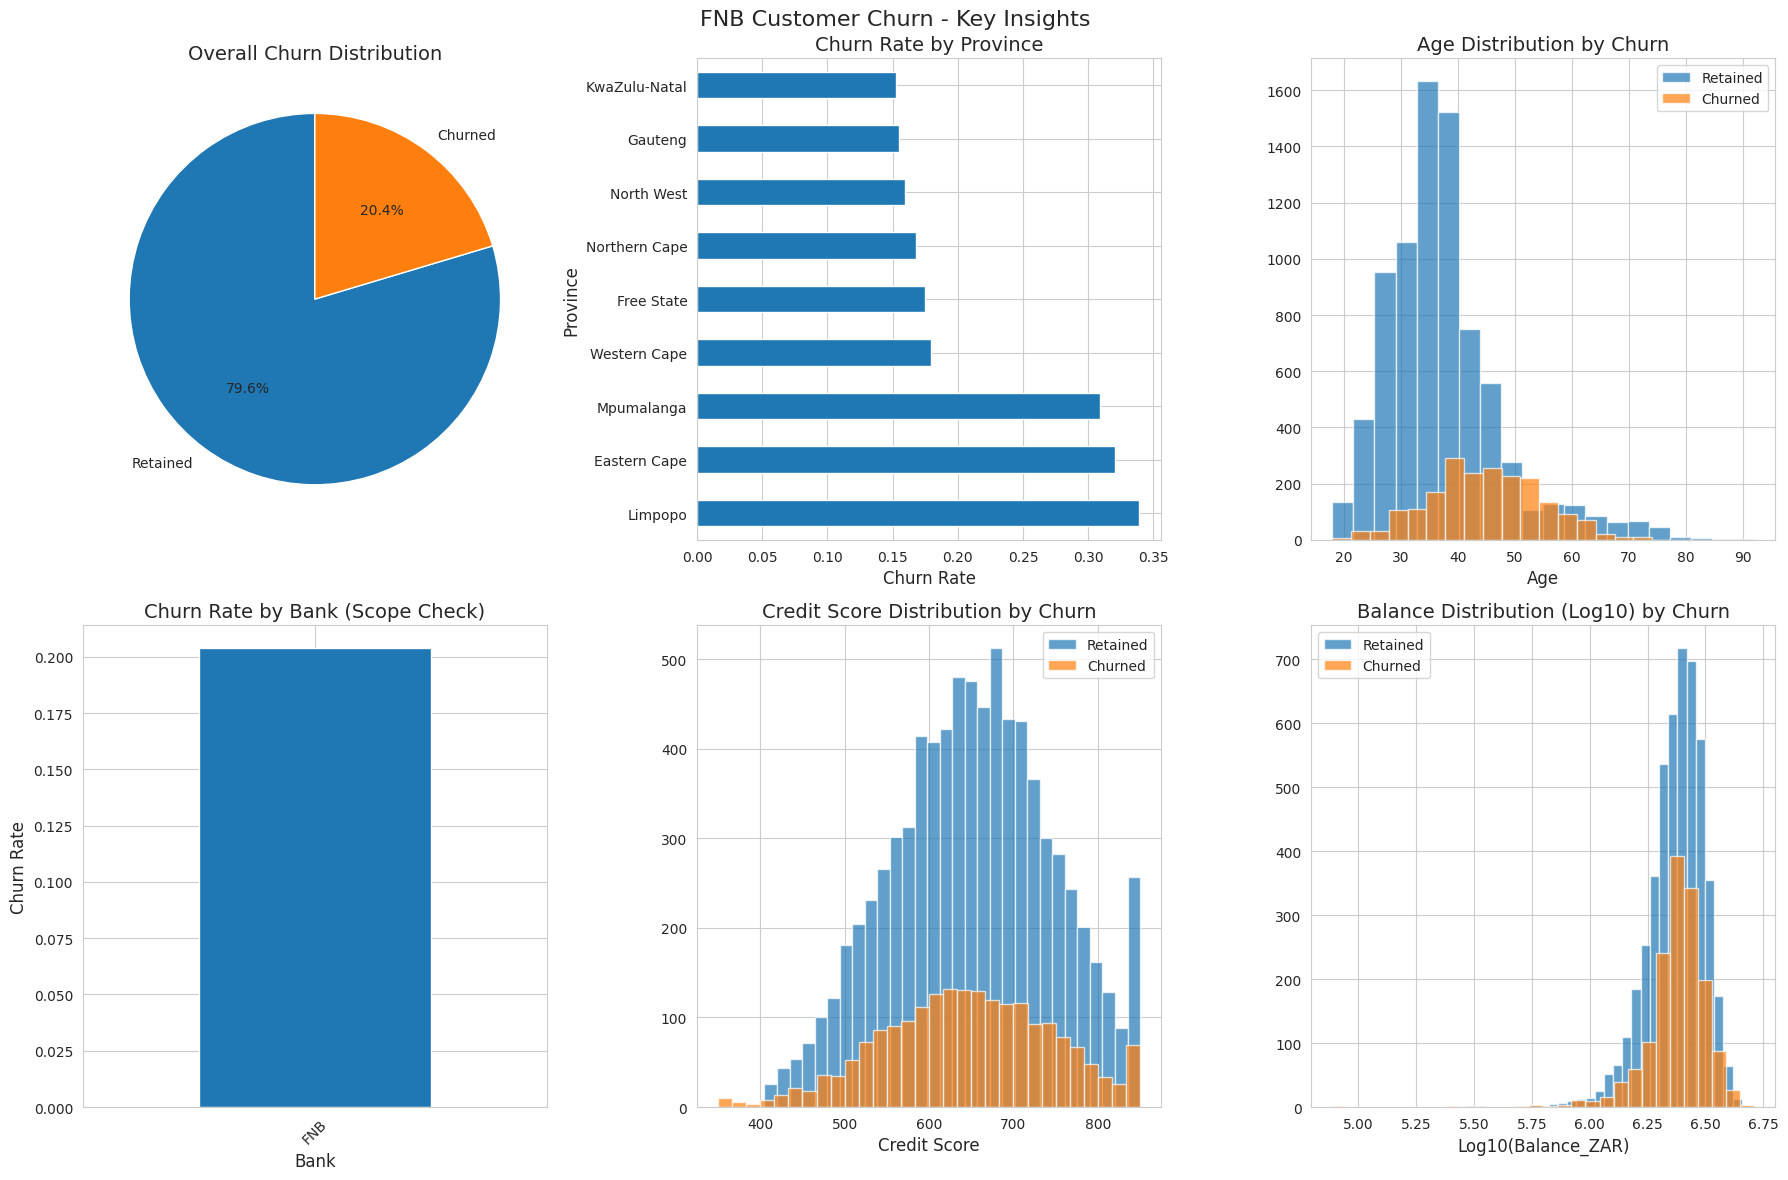

In [6]:
# -----------------------------
# Section 6. Key visualisations
# -----------------------------
# This section creates a small set of charts to summarise the key churn insights.
# The goal is to make results easier to interpret and easier to communicate.

print("\n" + "=" * 70)                                              # Visual separator
print("GENERATING VISUALISATIONS")                                  # Section title
print("=" * 70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))                    # Create a 2x3 grid of plots
fig.suptitle("FNB Customer Churn - Key Insights", fontsize=16)       # Overall title for the figure

# 1) Overall churn distribution
churn_counts = df["Churned"].value_counts()                          # Count churned vs retained
axes[0, 0].pie(
    churn_counts.values,                                             # Pie values
    labels=["Retained", "Churned"],                                   # Class labels
    autopct="%1.1f%%",                                               # Percentage labels
    startangle=90                                                    # Rotate for readability
)
axes[0, 0].set_title("Overall Churn Distribution")                   # Subplot title

# 2) Churn rate by province
churn_by_province = df.groupby("Province")["Churned"].mean().sort_values(ascending=False)  # Mean churn rate per province
churn_by_province.plot(kind="barh", ax=axes[0, 1])                   # Horizontal bar chart for readability
axes[0, 1].set_title("Churn Rate by Province")                       # Subplot title
axes[0, 1].set_xlabel("Churn Rate")                                  # Axis label

# 3) Age distribution by churn
df[df["Churned"] == 0]["Age"].hist(ax=axes[0, 2], bins=20, alpha=0.7, label="Retained")  # Retained age distribution
df[df["Churned"] == 1]["Age"].hist(ax=axes[0, 2], bins=20, alpha=0.7, label="Churned")   # Churned age distribution
axes[0, 2].set_title("Age Distribution by Churn")                    # Subplot title
axes[0, 2].set_xlabel("Age")                                         # Axis label
axes[0, 2].legend()                                                  # Show legend

# 4) Churn rate by bank (single-bank validation)
churn_by_bank = df.groupby("Bank")["Churned"].mean().sort_values(ascending=False)        # Mean churn rate per bank
churn_by_bank.plot(kind="bar", ax=axes[1, 0])                         # Bar chart
axes[1, 0].set_title("Churn Rate by Bank (Scope Check)")              # Subplot title
axes[1, 0].set_xlabel("Bank")                                         # Axis label
axes[1, 0].set_ylabel("Churn Rate")                                   # Axis label
axes[1, 0].tick_params(axis="x", rotation=45)                         # Rotate labels for readability

# 5) Credit score distribution by churn
df[df["Churned"] == 0]["CreditScore"].hist(ax=axes[1, 1], bins=30, alpha=0.7, label="Retained")  # Retained credit score distribution
df[df["Churned"] == 1]["CreditScore"].hist(ax=axes[1, 1], bins=30, alpha=0.7, label="Churned")   # Churned credit score distribution
axes[1, 1].set_title("Credit Score Distribution by Churn")            # Subplot title
axes[1, 1].set_xlabel("Credit Score")                                 # Axis label
axes[1, 1].legend()                                                   # Show legend

# 6) Balance distribution by churn (log scale to handle skewness)
df_with_balance = df[df["Balance_ZAR"] > 0].copy()                    # Filter to positive balances only
df_with_balance[df_with_balance["Churned"] == 0]["Balance_ZAR"].apply(np.log10).hist(
    ax=axes[1, 2], bins=30, alpha=0.7, label="Retained"
)                                                                     # Retained log-balance distribution
df_with_balance[df_with_balance["Churned"] == 1]["Balance_ZAR"].apply(np.log10).hist(
    ax=axes[1, 2], bins=30, alpha=0.7, label="Churned"
)                                                                     # Churned log-balance distribution
axes[1, 2].set_title("Balance Distribution (Log10) by Churn")         # Subplot title
axes[1, 2].set_xlabel("Log10(Balance_ZAR)")                            # Axis label
axes[1, 2].legend()                                                   # Show legend

plt.tight_layout()                                                    # Adjust spacing to prevent overlap
plt.savefig("fnb_churn_key_insights.png", dpi=300, bbox_inches="tight")  # Save figure for GitHub/README reuse
print("\nSaved visualisation as: fnb_churn_key_insights.png")          # Confirm save output
plt.show()                                                            # Display figure in Colab

## Section 7. Feature Inventory and Categorisation

This section documents the full set of features available in the dataset and organises them into logical groups from a banking and analytics perspective.

The purpose of this step is to:
- Create a clear mental model of the dataset structure.
- Distinguish between identifiers, predictors, and the target variable.
- Support feature selection decisions in later modelling stages.
- Make it easier to explain the dataset during interviews or stakeholder discussions.

Features are grouped into identifiers, demographics, banking information, products, financial attributes, engagement metrics, and the churn target.

In [7]:
# -----------------------------
# Section 7. Feature categories
# -----------------------------
# This section lists all dataset features grouped by logical category.
# It helps with feature understanding, documentation, and model design.

print("\n" + "=" * 70)                                  # Visual separator
print("FEATURE CATEGORIES")                             # Section title
print("=" * 70)

# Define feature groups based on business and analytical meaning
id_cols = ["RowNumber", "CustomerId", "Surname"]        # Unique identifiers

demographic_cols = [                                   # Customer demographics
    "Gender", "Age", "Province", "City", "AreaType",
    "EducationLevel", "EmploymentType", "PreferredLanguage"
]

banking_cols = [                                       # Core banking attributes
    "Bank", "AccountType", "Tenure",
    "CreditScore", "CreditRating", "CreditBureau"
]

product_cols = [                                       # Product ownership and bundles
    "NumOfProducts", "ProductName",
    "HasSavingsAccount", "HasChequeAccount",
    "HasCreditCard", "HasPersonalLoan",
    "HasHomeLoan", "HasVehicleFinance",
    "HasInvestmentAccount", "HasPremiumBanking",
    "HasCreditCard_Flag"
]

financial_cols = [                                     # Financial position and income
    "Balance_ZAR", "AnnualSalary_ZAR", "MonthlySalary_ZAR",
    "SalaryPaymentMethod", "FinancialWellnessScore"
]

engagement_cols = [                                    # Behaviour and engagement signals
    "IsActiveMember", "UsesMobileBanking", "UsesInternetBanking",
    "MonthlyBranchVisits", "MonthlyATMTransactions",
    "CustomerServiceCalls_12M", "Complaints_12M",
    "PreferredCommChannel"
]

target_col = ["Churned"]                                # Target variable

# Print feature groups with counts
print("\n1. ID Columns (3):")
for col in id_cols:
    print(f"  - {col}")

print("\n2. Demographics (8):")
for col in demographic_cols:
    print(f"  - {col}")

print("\n3. Banking Information (6):")
for col in banking_cols:
    print(f"  - {col}")

print("\n4. Products (11):")
for col in product_cols:
    print(f"  - {col}")

print("\n5. Financial (5):")
for col in financial_cols:
    print(f"  - {col}")

print("\n6. Engagement (8):")
for col in engagement_cols:
    print(f"  - {col}")

print("\nTarget Variable (1):")
print(f"  - {target_col[0]}")


FEATURE CATEGORIES

1. ID Columns (3):
  - RowNumber
  - CustomerId
  - Surname

2. Demographics (8):
  - Gender
  - Age
  - Province
  - City
  - AreaType
  - EducationLevel
  - EmploymentType
  - PreferredLanguage

3. Banking Information (6):
  - Bank
  - AccountType
  - Tenure
  - CreditScore
  - CreditRating
  - CreditBureau

4. Products (11):
  - NumOfProducts
  - ProductName
  - HasSavingsAccount
  - HasChequeAccount
  - HasCreditCard
  - HasPersonalLoan
  - HasHomeLoan
  - HasVehicleFinance
  - HasInvestmentAccount
  - HasPremiumBanking
  - HasCreditCard_Flag

5. Financial (5):
  - Balance_ZAR
  - AnnualSalary_ZAR
  - MonthlySalary_ZAR
  - SalaryPaymentMethod
  - FinancialWellnessScore

6. Engagement (8):
  - IsActiveMember
  - UsesMobileBanking
  - UsesInternetBanking
  - MonthlyBranchVisits
  - MonthlyATMTransactions
  - CustomerServiceCalls_12M
  - Complaints_12M
  - PreferredCommChannel

Target Variable (1):
  - Churned


## Section 8. Univariate Feature Analysis

This section performs a univariate analysis of the dataset, examining each feature independently.  
The objective is to understand the distribution, scale, and basic characteristics of individual variables before exploring relationships with churn.

At this stage, the analysis focuses on:
- Summary statistics for numerical features to understand central tendency and spread.
- Frequency distributions for categorical features to understand dominant customer segments.
- Identifying potential skewness, outliers, or low-variance features that may require attention later.

This step builds intuition around the data and informs which features are likely to be useful in downstream churn modelling.

In [8]:
# -----------------------------
# Section 8. Univariate analysis
# -----------------------------
# This section analyses individual features in isolation to understand
# their distributions and basic characteristics.

import numpy as np                                     # Numerical operations
import pandas as pd                                    # Data manipulation
import matplotlib.pyplot as plt                        # Plotting
import seaborn as sns                                  # Statistical visualisation
from scipy import stats                                # Statistical utilities
from scipy.stats import chi2_contingency, ttest_ind    # Hypothesis testing tools
import warnings
warnings.filterwarnings("ignore")                      # Suppress warnings for clean output


# Visual configuration for this section
plt.style.use("seaborn-v0_8-darkgrid")                  # Clean, readable plot style
sns.set_palette("husl")                                # Distinct colour palette
plt.rcParams["figure.figsize"] = (15, 8)               # Default figure size
plt.rcParams["font.size"] = 10                         # Base font size
plt.rcParams["axes.labelsize"] = 12                    # Axis label size
plt.rcParams["axes.titlesize"] = 14                    # Plot title size


print("\n" + "=" * 80)                                 # Section header
print("UNIVARIATE ANALYSIS")
print("=" * 80)

# Separate churned and retained customers for later comparisons
df_churned = df[df["Churned"] == 1]                     # Customers who churned
df_retained = df[df["Churned"] == 0]                    # Customers who stayed

# Identify numerical features (exclude identifiers and target)
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns = [col for col in numerical_columns
                     if col not in ["Churned", "RowNumber", "CustomerId"]]

print(f"\nNumerical features ({len(numerical_columns)}):")
print(df[numerical_columns].describe().round(2))        # Summary statistics

# Identify categorical features (exclude free-text identifiers)
categorical_columns = df.select_dtypes(include="object").columns.tolist()
categorical_columns = [col for col in categorical_columns if col != "Surname"]

print(f"\nCategorical features ({len(categorical_columns)}):")
for col in categorical_columns[:10]:                    # Limit output for readability
    print(f"\n{col}:")
    print(df[col].value_counts().head())                # Top categories


UNIVARIATE ANALYSIS

Numerical features (24):
            Age    Tenure  CreditScore  NumOfProducts  HasSavingsAccount  HasChequeAccount  HasCreditCard  \
count 10,000.00 10,000.00    10,000.00      10,000.00          10,000.00         10,000.00      10,000.00   
mean      38.92      5.01       650.53           1.53               1.00              0.71           0.49   
std       10.49      2.89        96.65           0.58               0.00              0.45           0.50   
min       18.00      0.00       350.00           1.00               1.00              0.00           0.00   
25%       32.00      3.00       584.00           1.00               1.00              0.00           0.00   
50%       37.00      5.00       652.00           1.00               1.00              1.00           0.00   
75%       44.00      7.00       718.00           2.00               1.00              1.00           1.00   
max       92.00     10.00       850.00           4.00               1.00         

## Section 9. Age Analysis

This section investigates how customer age relates to churn risk.  
Age is often a strong churn driver in retail banking because it links to life stage, income stability, product needs, and switching behaviour.

The analysis includes:
- Summary statistics comparing churned vs retained customers.
- A statistical test to evaluate whether the age difference is meaningful.
- Age banding to translate continuous age into interpretable customer segments.
- Visualisations to compare distributions and churn rates by age group.

The goal is to identify age segments with elevated churn risk and quantify the strength of the relationship.


AGE ANALYSIS

Age statistics:
Overall mean age: 38.9 years
Churned mean age: 44.8 years
Retained mean age: 37.4 years

T-test for age difference: t=29.767, p-value=0.0000
Result: statistically significant age difference between churned and retained

Churn rate by age group:
          count  churn_rate_%
AgeGroup                     
18-25       611          7.53
26-35      3542          8.50
36-45      3736         19.62
46-55      1311         50.57
56-65       536         48.32
65+         264         13.26

Saved: eda_age_analysis.png


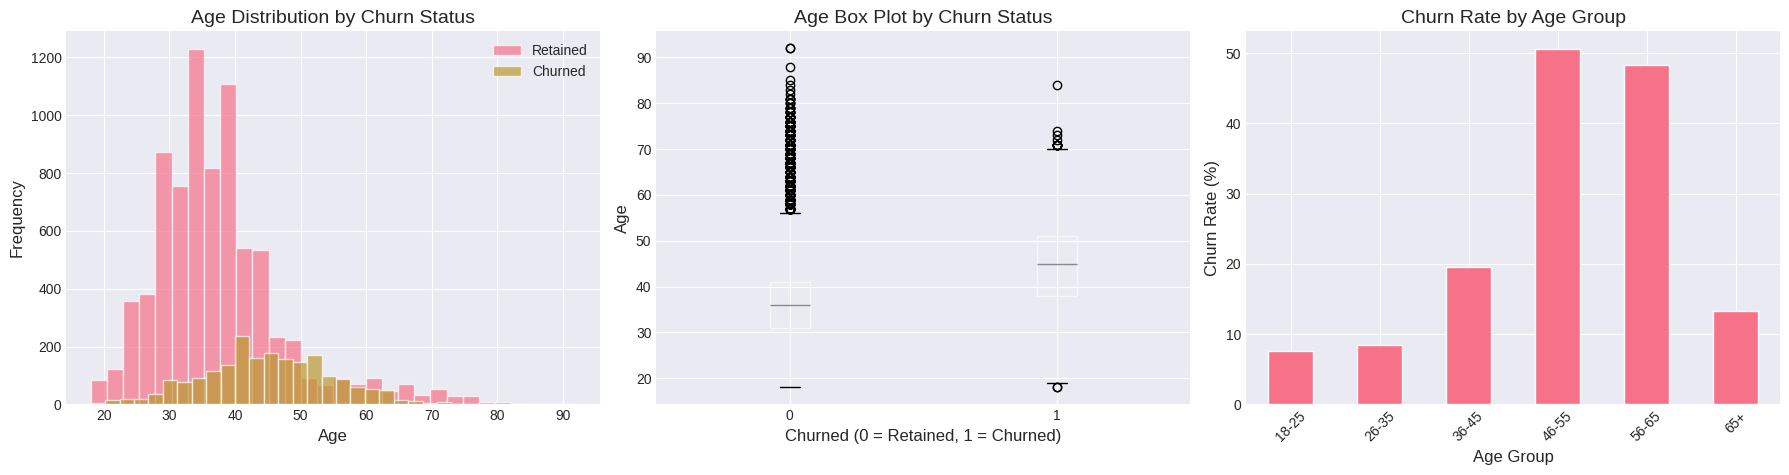

In [9]:
 # -----------------------------
# Section 9. Age analysis
# -----------------------------
# This section examines how age relates to churn, using both descriptive statistics
# and a simple hypothesis test to quantify the difference between churned and retained customers.

print("\n" + "=" * 80)                                  # Section header
print("AGE ANALYSIS")
print("=" * 80)

# Basic age statistics
print("\nAge statistics:")                               # Summary view of central tendency
print(f"Overall mean age: {df['Age'].mean():.1f} years")  # Mean age across all customers
print(f"Churned mean age: {df_churned['Age'].mean():.1f} years")   # Mean age for churned customers
print(f"Retained mean age: {df_retained['Age'].mean():.1f} years") # Mean age for retained customers

# T-test: compare churned vs retained mean age
t_stat, p_value = ttest_ind(df_churned["Age"], df_retained["Age"])  # Independent samples t-test
print(f"\nT-test for age difference: t={t_stat:.3f}, p-value={p_value:.4f}")  # Statistical significance
if p_value < 0.05:
    print("Result: statistically significant age difference between churned and retained")  # Interpretation
else:
    print("Result: no statistically significant age difference detected")                  # Interpretation

# Create age groups for business interpretation
df["AgeGroup"] = pd.cut(
    df["Age"],
    bins=[0, 25, 35, 45, 55, 65, 100],
    labels=["18-25", "26-35", "36-45", "46-55", "56-65", "65+"]
)                                                    # Convert continuous age to interpretable segments

# Churn rate by age group
print("\nChurn rate by age group:")                   # Segment-level churn view
age_churn = df.groupby("AgeGroup")["Churned"].agg(["mean", "count"])  # Mean churn and sample size
age_churn["churn_rate_%"] = (age_churn["mean"] * 100).round(2)        # Convert churn rate to percent
print(age_churn[["count", "churn_rate_%"]])           # Display churn by age segment

# Visualisations: distribution + comparison + churn by age group
fig, axes = plt.subplots(1, 3, figsize=(18, 5))       # Three-panel plot layout

# 1) Age distribution by churn status
axes[0].hist(df_retained["Age"], bins=30, alpha=0.7, label="Retained")  # Retained distribution
axes[0].hist(df_churned["Age"], bins=30, alpha=0.7, label="Churned")    # Churned distribution
axes[0].set_xlabel("Age")                                # X-axis label
axes[0].set_ylabel("Frequency")                          # Y-axis label
axes[0].set_title("Age Distribution by Churn Status")    # Plot title
axes[0].legend()                                         # Legend for group labels

# 2) Box plot: age spread by churn
df.boxplot(column="Age", by="Churned", ax=axes[1])        # Boxplot grouped by churn status
axes[1].set_xlabel("Churned (0 = Retained, 1 = Churned)") # X-axis label
axes[1].set_ylabel("Age")                                 # Y-axis label
axes[1].set_title("Age Box Plot by Churn Status")         # Plot title
plt.suptitle("")                                          # Remove default pandas title

# 3) Churn rate by age group
age_churn["churn_rate_%"].plot(kind="bar", ax=axes[2])     # Bar chart for churn percent
axes[2].set_xlabel("Age Group")                            # X-axis label
axes[2].set_ylabel("Churn Rate (%)")                       # Y-axis label
axes[2].set_title("Churn Rate by Age Group")               # Plot title
axes[2].tick_params(axis="x", rotation=45)                 # Rotate labels for readability

plt.tight_layout()                                         # Prevent overlapping labels
plt.savefig("eda_age_analysis.png", dpi=300, bbox_inches="tight")  # Save for GitHub/README reuse
print("\nSaved: eda_age_analysis.png")                      # Confirmation message
plt.show()                                                  # Display in Colab

## Section 10. Geographic Analysis

This section analyses churn patterns across geography using province, city, and area type.  
Geographic segmentation is useful in retail banking because churn often varies by region due to differences in service access, branch density, local competition, and customer demographics.

The analysis includes:
- Province-level churn rates with supporting financial context such as average balance and income.
- A chi-square test to evaluate whether churn is statistically associated with province.
- Visualisations that summarise churn exposure by province, customer distribution, high-risk cities, and urban versus rural differences.

The goal is to identify geographic segments that show elevated churn risk and require targeted retention strategies.


GEOGRAPHIC ANALYSIS

Churn analysis by province:
               Churn_Rate  Count  Avg_Balance   Avg_Salary  Churn_Rate_%
Province                                                                
Limpopo              0.34    894 2,482,157.33 2,088,064.32         34.00
Eastern Cape         0.32   1017 2,438,692.72 2,036,011.65         32.00
Mpumalanga           0.31    598 2,439,898.83 2,112,651.56         31.00
Western Cape         0.18   1468 1,247,558.97 2,018,587.73         18.00
Free State           0.17    859 1,251,705.61 2,072,851.69         17.00
Northern Cape        0.17    596 1,306,702.73 1,981,438.07         17.00
North West           0.16   1022 1,257,360.93 2,042,980.83         16.00
KwaZulu-Natal        0.15    988 1,290,093.90 2,094,172.22         15.00
Gauteng              0.15   2558 1,280,800.04 2,046,914.84         15.00

Chi-square test (Province vs Churn): χ²=307.993, p-value=0.0000
Result: churn is statistically associated with province

Saved: eda_geographic_ana

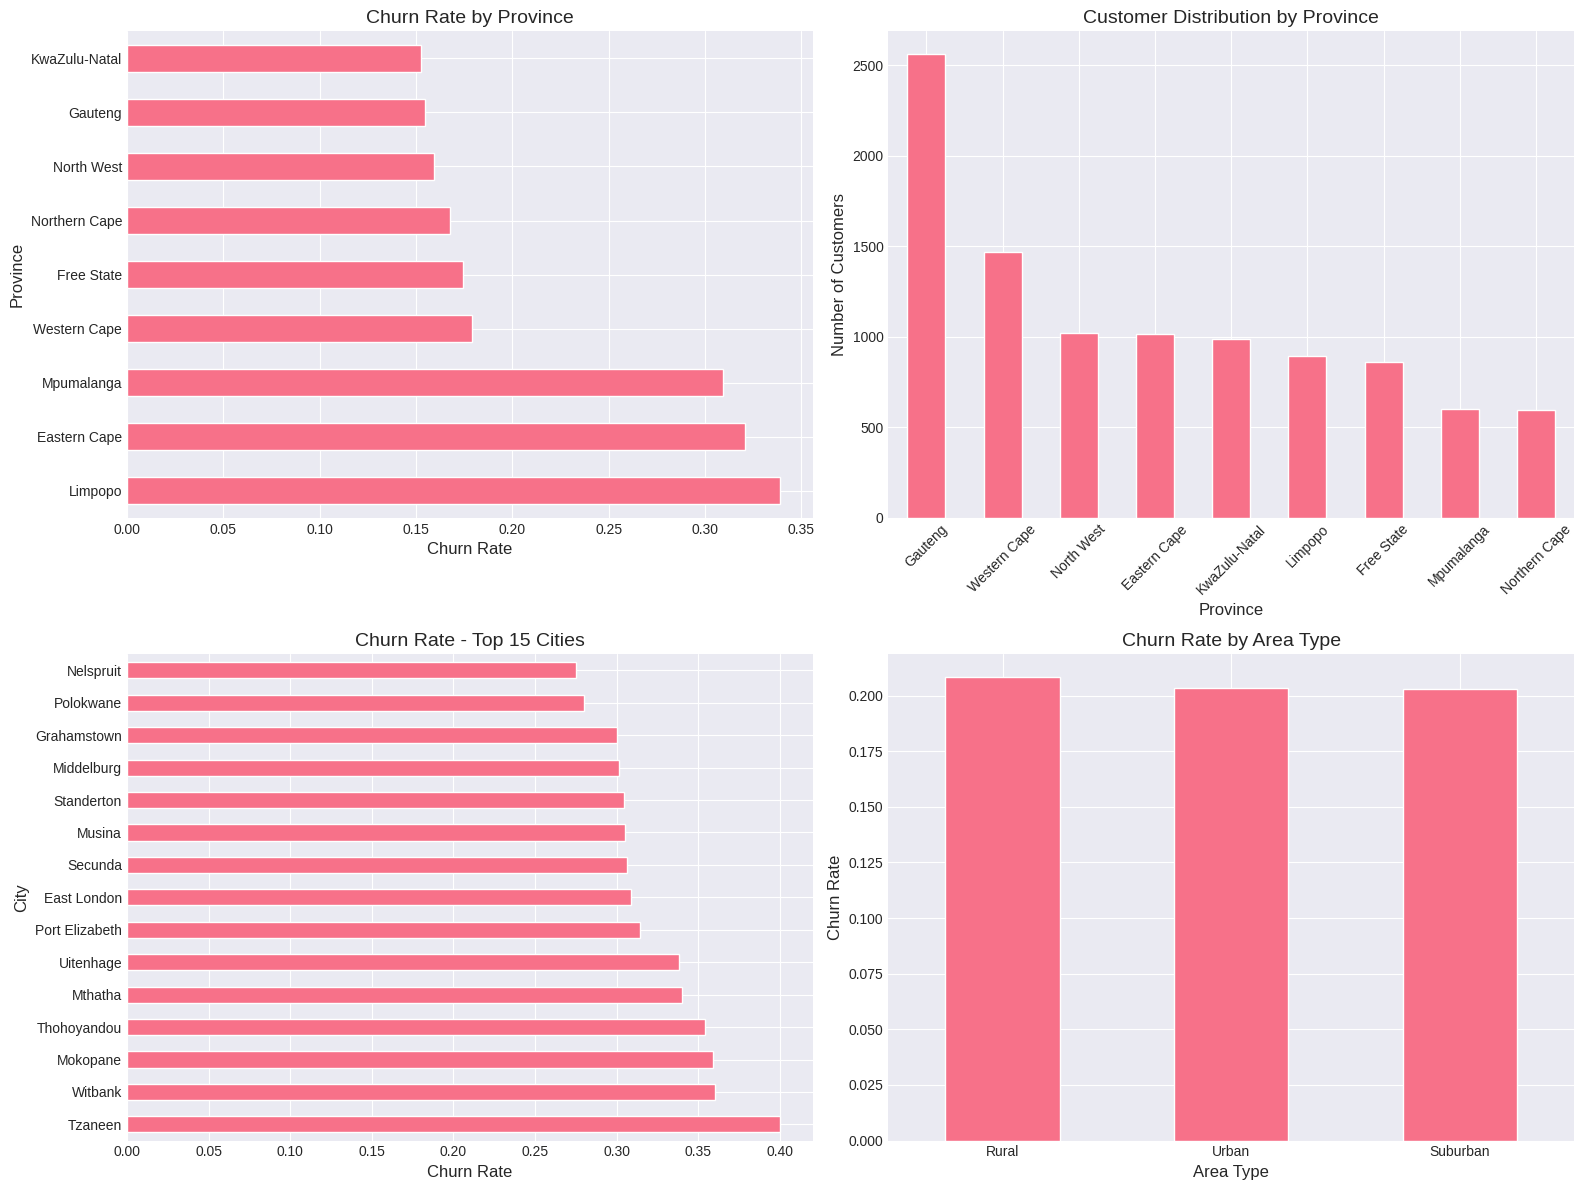

In [10]:
# -----------------------------
# Section 10. Geographic analysis
# -----------------------------
# This section evaluates churn patterns across Province, City, and AreaType.
# It also tests whether churn and province are statistically associated.

print("\n" + "=" * 80)                                              # Section header
print("GEOGRAPHIC ANALYSIS")
print("=" * 80)

# Province-level churn and financial context
print("\nChurn analysis by province:")                               # Province segmentation output
province_analysis = df.groupby("Province").agg({                     # Aggregate churn + financial variables
    "Churned": ["mean", "count"],                                    # Churn rate and sample size
    "Balance_ZAR": "mean",                                           # Average balance per province
    "AnnualSalary_ZAR": "mean"                                       # Average annual salary per province
}).round(2)

province_analysis.columns = ["Churn_Rate", "Count", "Avg_Balance", "Avg_Salary"]  # Flatten multi-index columns
province_analysis["Churn_Rate_%"] = (province_analysis["Churn_Rate"] * 100).round(2)  # Convert to percentage
province_analysis = province_analysis.sort_values("Churn_Rate_%", ascending=False)    # Rank by churn exposure
print(province_analysis)                                              # Display result table

# Chi-square test: Province vs Churn
contingency_table = pd.crosstab(df["Province"], df["Churned"])        # Build contingency table for chi-square
chi2, p_value, dof, expected = chi2_contingency(contingency_table)    # Chi-square test of independence
print(f"\nChi-square test (Province vs Churn): χ²={chi2:.3f}, p-value={p_value:.4f}")  # Report test output
if p_value < 0.05:
    print("Result: churn is statistically associated with province")  # Interpretation when significant
else:
    print("Result: no statistically significant association detected")# Interpretation when not significant

# Visualisations: province, city, and area type views
fig, axes = plt.subplots(2, 2, figsize=(16, 12))                      # Create 2x2 visual grid

# 1) Churn rate by province
province_churn = df.groupby("Province")["Churned"].mean().sort_values(ascending=False)  # Mean churn by province
province_churn.plot(kind="barh", ax=axes[0, 0])                        # Horizontal bar chart
axes[0, 0].set_xlabel("Churn Rate")                                    # Axis label
axes[0, 0].set_title("Churn Rate by Province")                         # Plot title

# 2) Customer distribution by province
df["Province"].value_counts().plot(kind="bar", ax=axes[0, 1])          # Customer counts per province
axes[0, 1].set_xlabel("Province")                                      # Axis label
axes[0, 1].set_ylabel("Number of Customers")                           # Axis label
axes[0, 1].set_title("Customer Distribution by Province")              # Plot title
axes[0, 1].tick_params(axis="x", rotation=45)                          # Rotate labels for readability

# 3) Top 15 cities by churn rate
city_churn = df.groupby("City")["Churned"].mean().sort_values(ascending=False).head(15)  # Top churn cities
city_churn.plot(kind="barh", ax=axes[1, 0])                             # Horizontal bar chart
axes[1, 0].set_xlabel("Churn Rate")                                     # Axis label
axes[1, 0].set_title("Churn Rate - Top 15 Cities")                      # Plot title

# 4) Churn rate by area type
area_churn = df.groupby("AreaType")["Churned"].mean().sort_values(ascending=False)       # Mean churn by area type
area_churn.plot(kind="bar", ax=axes[1, 1])                               # Bar chart
axes[1, 1].set_xlabel("Area Type")                                       # Axis label
axes[1, 1].set_ylabel("Churn Rate")                                      # Axis label
axes[1, 1].set_title("Churn Rate by Area Type")                           # Plot title
axes[1, 1].tick_params(axis="x", rotation=0)                              # Keep labels horizontal

plt.tight_layout()                                                       # Prevent plot overlap
plt.savefig("eda_geographic_analysis.png", dpi=300, bbox_inches="tight") # Save for GitHub/README reuse
print("\nSaved: eda_geographic_analysis.png")                             # Confirmation message
plt.show()                                                                # Display in Colab

## Section 11. Financial Analysis

This section evaluates how financial position relates to churn risk.  
In retail banking, churn is often linked to customer value, income stability, product suitability, and service expectations.

The analysis focuses on:
- Comparing balance, salary, and financial wellness between churned and retained customers.
- Quantifying the prevalence of zero-balance customers, since this segment often behaves differently.
- Visualising key financial distributions using log scaling where necessary to handle skewness.
- Segmenting customers into balance bands to support business interpretation.
- Reviewing churn patterns across salary payment methods.
- Inspecting the relationship between income and balance to understand customer value clusters.

The goal is to identify financially meaningful churn segments and inform retention strategies.


FINANCIAL ANALYSIS

Financial metrics by churn status:
                             Retained      Churned
Avg Balance (ZAR)        1,491,278.58 1,867,725.06
Median Balance (ZAR)     1,887,489.94 2,241,660.44
Avg Annual Salary (ZAR)  2,044,637.03 2,080,046.39
Avg Monthly Salary (ZAR)   170,386.42   173,337.20
Financial Wellness Score         5.43         5.65

Balance distribution:
Zero balance customers: 3,617 (36.2%)
  - Among churned: 500 (24.5%)
  - Among retained: 3,117 (39.1%)

Saved: eda_financial_analysis.png


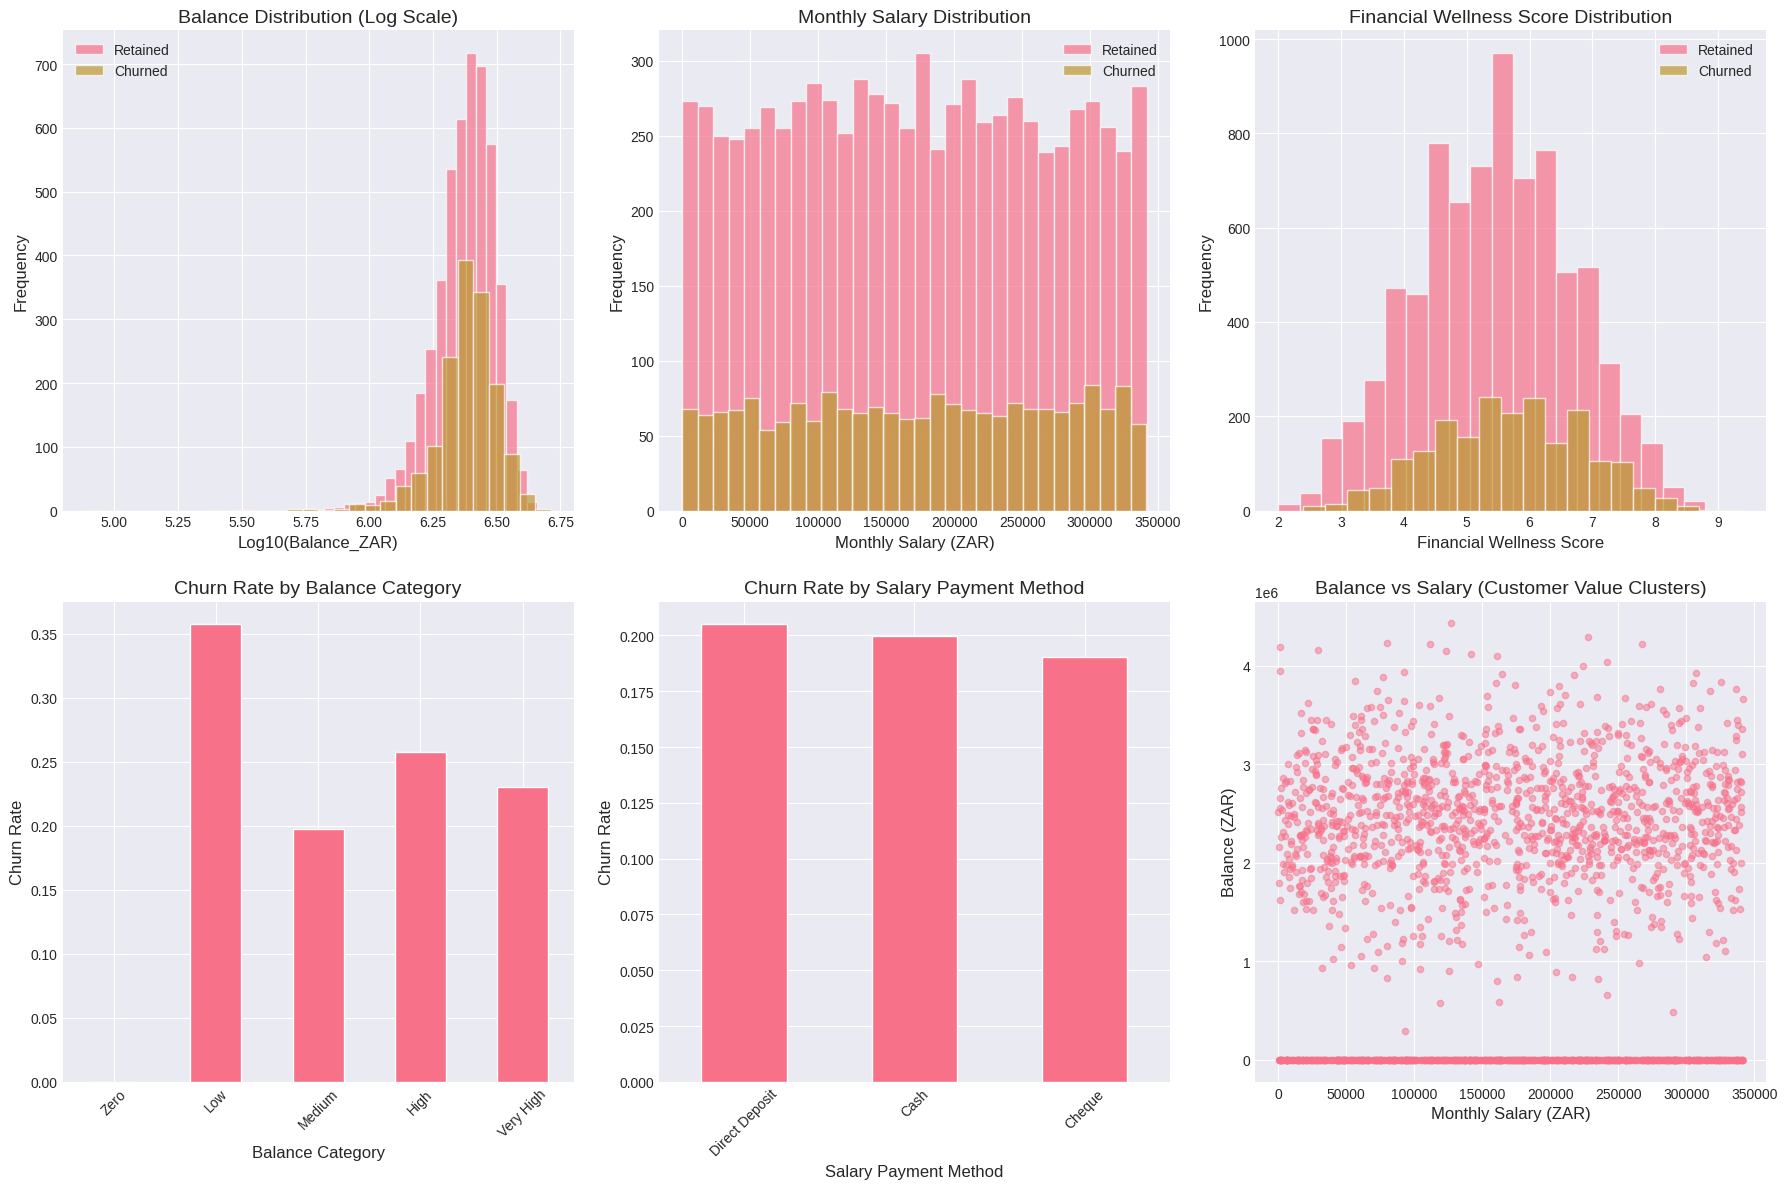

In [11]:
# -----------------------------
# Section 11. Financial analysis
# -----------------------------
# This section compares financial metrics between churned and retained customers
# and creates visuals to highlight financial drivers of churn.

print("\n" + "=" * 80)                                               # Section header
print("FINANCIAL ANALYSIS")
print("=" * 80)

# Financial metrics comparison table
print("\nFinancial metrics by churn status:")                         # Summary comparison output
financial_comparison = pd.DataFrame({                                 # Build retained vs churned table
    "Retained": [
        df_retained["Balance_ZAR"].mean(),                             # Average balance for retained
        df_retained["Balance_ZAR"].median(),                           # Median balance for retained
        df_retained["AnnualSalary_ZAR"].mean(),                        # Average annual salary for retained
        df_retained["MonthlySalary_ZAR"].mean(),                       # Average monthly salary for retained
        df_retained["FinancialWellnessScore"].mean()                   # Average wellness score for retained
    ],
    "Churned": [
        df_churned["Balance_ZAR"].mean(),                              # Average balance for churned
        df_churned["Balance_ZAR"].median(),                            # Median balance for churned
        df_churned["AnnualSalary_ZAR"].mean(),                         # Average annual salary for churned
        df_churned["MonthlySalary_ZAR"].mean(),                        # Average monthly salary for churned
        df_churned["FinancialWellnessScore"].mean()                    # Average wellness score for churned
    ]
}, index=[
    "Avg Balance (ZAR)",                                               # Row label
    "Median Balance (ZAR)",                                            # Row label
    "Avg Annual Salary (ZAR)",                                         # Row label
    "Avg Monthly Salary (ZAR)",                                        # Row label
    "Financial Wellness Score"                                         # Row label
])

print(financial_comparison.round(2))                                   # Print formatted comparison table

# Zero balance analysis (common segment in churn datasets)
print("\nBalance distribution:")                                       # Zero-balance context
zero_balance_total = (df["Balance_ZAR"] == 0).sum()                    # Count zero balances overall
zero_balance_rate = (df["Balance_ZAR"] == 0).mean()                    # Proportion zero balances overall
print(f"Zero balance customers: {zero_balance_total:,} ({zero_balance_rate:.1%})")  # Overall metric

zero_balance_churned = (df_churned["Balance_ZAR"] == 0).sum()          # Count zero balances among churned
zero_balance_churned_rate = (df_churned["Balance_ZAR"] == 0).mean()    # Proportion zero balances among churned
print(f"  - Among churned: {zero_balance_churned:,} ({zero_balance_churned_rate:.1%})")  # Churned segment

zero_balance_retained = (df_retained["Balance_ZAR"] == 0).sum()        # Count zero balances among retained
zero_balance_retained_rate = (df_retained["Balance_ZAR"] == 0).mean()  # Proportion zero balances among retained
print(f"  - Among retained: {zero_balance_retained:,} ({zero_balance_retained_rate:.1%})")  # Retained segment

# Visualisations: financial distributions and churn segments
fig, axes = plt.subplots(2, 3, figsize=(18, 12))                       # 2x3 plot layout

# 1) Balance distribution (log scale, non-zero only)
df_with_balance = df[df["Balance_ZAR"] > 0].copy()                     # Filter to positive balances
retained_bal = df_with_balance[df_with_balance["Churned"] == 0]["Balance_ZAR"]  # Retained balances
churned_bal = df_with_balance[df_with_balance["Churned"] == 1]["Balance_ZAR"]   # Churned balances

axes[0, 0].hist(np.log10(retained_bal), bins=30, alpha=0.7, label="Retained")   # Retained log balance histogram
axes[0, 0].hist(np.log10(churned_bal), bins=30, alpha=0.7, label="Churned")     # Churned log balance histogram
axes[0, 0].set_xlabel("Log10(Balance_ZAR)")                             # Axis label
axes[0, 0].set_ylabel("Frequency")                                      # Axis label
axes[0, 0].set_title("Balance Distribution (Log Scale)")                # Plot title
axes[0, 0].legend()                                                     # Legend

# 2) Monthly salary distribution
axes[0, 1].hist(df_retained["MonthlySalary_ZAR"], bins=30, alpha=0.7, label="Retained")  # Retained salary histogram
axes[0, 1].hist(df_churned["MonthlySalary_ZAR"], bins=30, alpha=0.7, label="Churned")    # Churned salary histogram
axes[0, 1].set_xlabel("Monthly Salary (ZAR)")                           # Axis label
axes[0, 1].set_ylabel("Frequency")                                      # Axis label
axes[0, 1].set_title("Monthly Salary Distribution")                     # Plot title
axes[0, 1].legend()                                                     # Legend

# 3) Financial wellness score distribution
axes[0, 2].hist(df_retained["FinancialWellnessScore"], bins=20, alpha=0.7, label="Retained")  # Retained wellness histogram
axes[0, 2].hist(df_churned["FinancialWellnessScore"], bins=20, alpha=0.7, label="Churned")    # Churned wellness histogram
axes[0, 2].set_xlabel("Financial Wellness Score")                       # Axis label
axes[0, 2].set_ylabel("Frequency")                                      # Axis label
axes[0, 2].set_title("Financial Wellness Score Distribution")           # Plot title
axes[0, 2].legend()                                                     # Legend

# 4) Balance categories and churn rate
df["BalanceCategory"] = pd.cut(                                         # Create interpretable balance bands
    df["Balance_ZAR"],
    bins=[0, 1, 1_000_000, 2_000_000, 3_000_000, np.inf],
    labels=["Zero", "Low", "Medium", "High", "Very High"]
)

balance_category_churn = df.groupby("BalanceCategory")["Churned"].mean()  # Mean churn per balance band
balance_category_churn.plot(kind="bar", ax=axes[1, 0])                    # Bar chart
axes[1, 0].set_xlabel("Balance Category")                                 # Axis label
axes[1, 0].set_ylabel("Churn Rate")                                       # Axis label
axes[1, 0].set_title("Churn Rate by Balance Category")                    # Plot title
axes[1, 0].tick_params(axis="x", rotation=45)                             # Rotate for readability

# 5) Salary payment method and churn rate
salary_method_churn = df.groupby("SalaryPaymentMethod")["Churned"].mean().sort_values(ascending=False)  # Churn by payment method
salary_method_churn.plot(kind="bar", ax=axes[1, 1])                       # Bar chart
axes[1, 1].set_xlabel("Salary Payment Method")                            # Axis label
axes[1, 1].set_ylabel("Churn Rate")                                       # Axis label
axes[1, 1].set_title("Churn Rate by Salary Payment Method")               # Plot title
axes[1, 1].tick_params(axis="x", rotation=45)                             # Rotate for readability

# 6) Balance vs Salary scatter (sampled for performance)
sample = df.sample(min(2000, len(df)), random_state=42)                   # Sample to keep plot responsive
axes[1, 2].scatter(sample["MonthlySalary_ZAR"], sample["Balance_ZAR"], alpha=0.5, s=20)  # Scatter plot
axes[1, 2].set_xlabel("Monthly Salary (ZAR)")                             # Axis label
axes[1, 2].set_ylabel("Balance (ZAR)")                                    # Axis label
axes[1, 2].set_title("Balance vs Salary (Customer Value Clusters)")       # Plot title

plt.tight_layout()                                                        # Prevent overlap
plt.savefig("eda_financial_analysis.png", dpi=300, bbox_inches="tight")    # Save for GitHub/README reuse
print("\nSaved: eda_financial_analysis.png")                               # Confirmation message
plt.show()                                                                 # Display in Colab

## Section 12. Credit Score Analysis

This section evaluates how credit risk relates to churn.  
In retail banking, credit score often correlates with product eligibility, pricing, customer financial stability, and risk appetite, which can influence churn behaviour.

The analysis includes:
- Comparing average credit scores between churned and retained customers.
- A statistical test to assess whether observed differences are meaningful.
- Churn rates across TransUnion-style credit rating categories for business interpretability.
- Visualisations to compare distributions, spread, and segment-level churn exposure.

The goal is to identify whether churn concentrates in specific credit risk bands and whether credit score is likely to be a useful predictor in modelling.


CREDIT SCORE ANALYSIS

Credit score statistics:
Overall mean credit score: 651
Churned mean credit score: 645
Retained mean credit score: 652

T-test for credit score difference: t=-2.710, p-value=0.0067

Churn rate by credit rating:
              count  churn_rate_%
CreditRating                     
Poor           2362         22.02
Fair           3331         20.56
Good           2428         18.62
Very Good      1224         20.59
Excellent       655         19.54

Saved: eda_credit_analysis.png


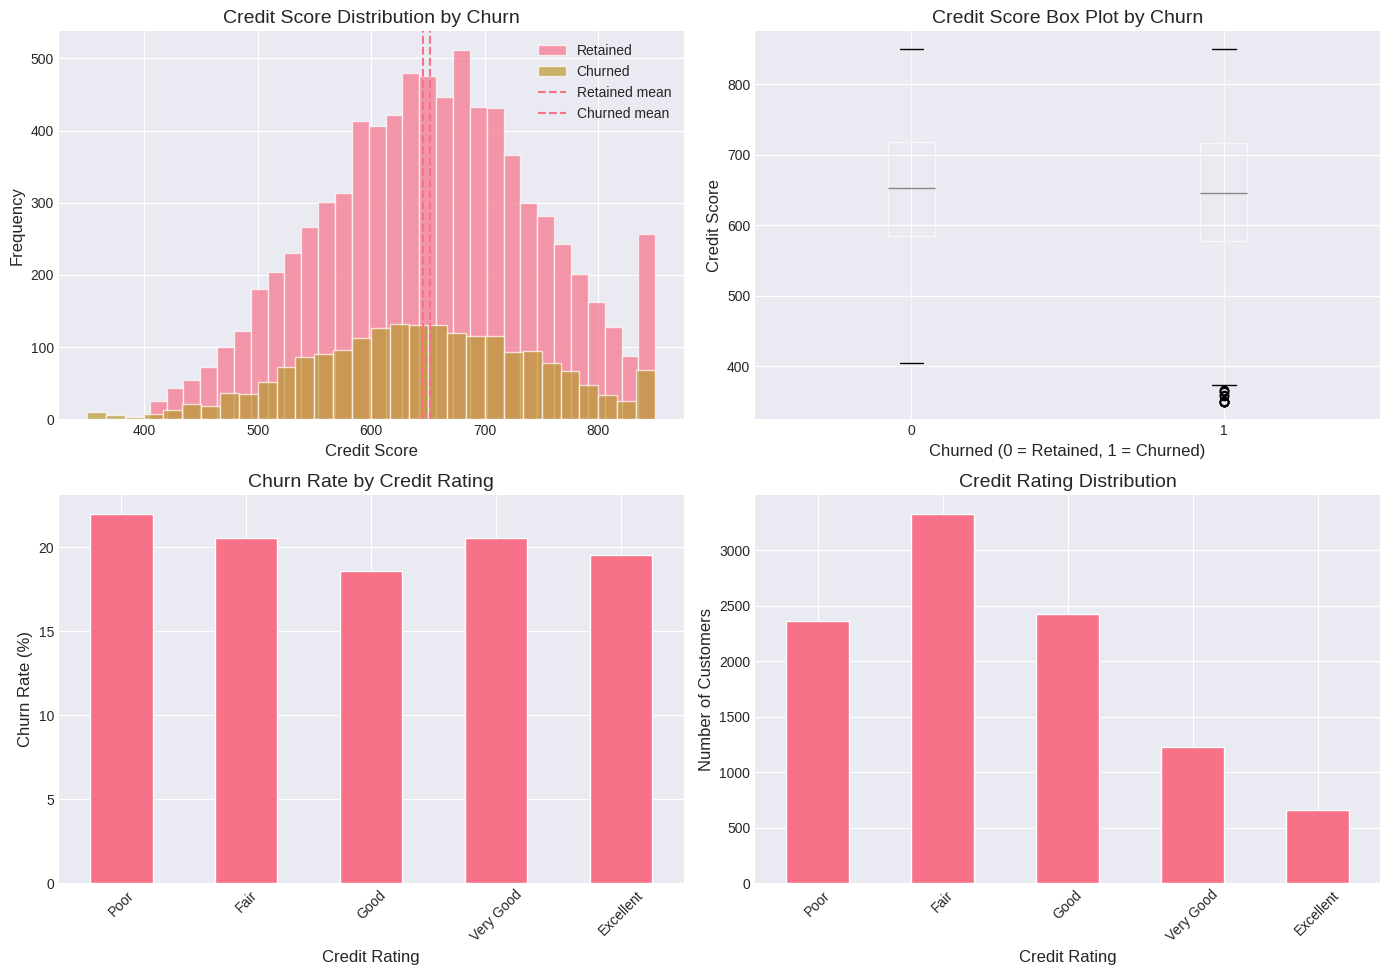

In [12]:
# -----------------------------
# Section 12. Credit score analysis
# -----------------------------
# This section explores the relationship between credit risk and churn
# using descriptive statistics, a t-test, and segment-level churn rates.

print("\n" + "=" * 80)                                               # Section header
print("CREDIT SCORE ANALYSIS")
print("=" * 80)

# Credit score statistics
print("\nCredit score statistics:")                                   # Summary view of central tendency
print(f"Overall mean credit score: {df['CreditScore'].mean():.0f}")   # Mean credit score overall
print(f"Churned mean credit score: {df_churned['CreditScore'].mean():.0f}")   # Mean score among churned
print(f"Retained mean credit score: {df_retained['CreditScore'].mean():.0f}") # Mean score among retained

# T-test: compare churned vs retained mean credit score
t_stat, p_value = ttest_ind(df_churned["CreditScore"], df_retained["CreditScore"])  # Independent samples t-test
print(f"\nT-test for credit score difference: t={t_stat:.3f}, p-value={p_value:.4f}")  # Statistical output

# Churn rate by credit rating category
print("\nChurn rate by credit rating:")                               # Segment-level churn exposure
credit_churn = df.groupby("CreditRating")["Churned"].agg(["mean", "count"])  # Mean churn and sample size
credit_churn["churn_rate_%"] = (credit_churn["mean"] * 100).round(2)         # Convert to percentage

# Enforce business ordering of credit rating categories
credit_order = ["Poor", "Fair", "Good", "Very Good", "Excellent"]     # Desired category order
credit_churn = credit_churn.reindex(credit_order)                      # Apply ordering
print(credit_churn[["count", "churn_rate_%"]])                         # Display segment churn table

# Visualisations: distribution + churn by segment
fig, axes = plt.subplots(2, 2, figsize=(14, 10))                       # Create 2x2 plot layout

# 1) Credit score distribution by churn status
axes[0, 0].hist(df_retained["CreditScore"], bins=30, alpha=0.7, label="Retained")  # Retained distribution
axes[0, 0].hist(df_churned["CreditScore"], bins=30, alpha=0.7, label="Churned")    # Churned distribution
axes[0, 0].set_xlabel("Credit Score")                                   # Axis label
axes[0, 0].set_ylabel("Frequency")                                      # Axis label
axes[0, 0].set_title("Credit Score Distribution by Churn")              # Plot title

axes[0, 0].axvline(df_retained["CreditScore"].mean(), linestyle="--", label="Retained mean")  # Retained mean marker
axes[0, 0].axvline(df_churned["CreditScore"].mean(), linestyle="--", label="Churned mean")    # Churned mean marker
axes[0, 0].legend()                                                     # Legend

# 2) Box plot: credit score spread by churn
df.boxplot(column="CreditScore", by="Churned", ax=axes[0, 1])            # Boxplot grouped by churn status
axes[0, 1].set_xlabel("Churned (0 = Retained, 1 = Churned)")             # Axis label
axes[0, 1].set_ylabel("Credit Score")                                    # Axis label
axes[0, 1].set_title("Credit Score Box Plot by Churn")                   # Plot title
plt.suptitle("")                                                         # Remove default pandas title

# 3) Churn rate by credit rating category
credit_churn["churn_rate_%"].plot(kind="bar", ax=axes[1, 0])              # Bar chart of churn percent
axes[1, 0].set_xlabel("Credit Rating")                                    # Axis label
axes[1, 0].set_ylabel("Churn Rate (%)")                                   # Axis label
axes[1, 0].set_title("Churn Rate by Credit Rating")                       # Plot title
axes[1, 0].tick_params(axis="x", rotation=45)                             # Rotate for readability

# 4) Credit rating distribution (customer counts)
df["CreditRating"].value_counts().reindex(credit_order).plot(kind="bar", ax=axes[1, 1])  # Distribution by category
axes[1, 1].set_xlabel("Credit Rating")                                    # Axis label
axes[1, 1].set_ylabel("Number of Customers")                              # Axis label
axes[1, 1].set_title("Credit Rating Distribution")                        # Plot title
axes[1, 1].tick_params(axis="x", rotation=45)                             # Rotate for readability

plt.tight_layout()                                                        # Prevent overlap
plt.savefig("eda_credit_analysis.png", dpi=300, bbox_inches="tight")       # Save for GitHub/README reuse
print("\nSaved: eda_credit_analysis.png")                                  # Confirmation message
plt.show()                                                                 # Display in Colab

## Section 13. Banking Products and Service Profile

This section analyses churn across core banking attributes and product ownership.  
In retail banking, churn risk often changes with product depth, account type, tenure, and relationship strength. Customers with more products and deeper engagement typically have higher switching costs, while shallow relationships can be easier to exit.

The analysis focuses on:
- Churn rate by bank as a scope check, since this project is focused on FNB only.
- Churn rate by number of products to understand the link between product depth and retention.
- Churn rate by account type to identify vulnerable customer segments.
- Churn rate by specific product ownership flags to evaluate which products align with stronger retention.
- Visual summaries of churn patterns, product adoption, tenure distribution, and active member status.

The goal is to identify relationship depth signals that are likely to be strong churn predictors in modelling.


BANKING PRODUCTS ANALYSIS

Churn rate by bank (scope check):
      Churn_Rate  Count  Avg_Products  Churn_Rate_%
Bank                                               
FNB         0.20  10000          1.53         20.40

Churn rate by number of products:
               count  churn_rate_%
NumOfProducts                     
1               5084         27.71
2               4590          7.58
3                266         82.71
4                 60        100.00

Churn rate by account type:
             count  churn_rate_%
AccountType                     
Cheque        3525         21.02
Prestige      1440         20.42
Savings       4004         20.10
Student        510         19.80
Pensioner      521         18.43

Churn rate by product ownership:
HasChequeAccount: With=19.98%, Without=21.32%
HasCreditCard: With=12.77%, Without=27.71%
HasPersonalLoan: With=85.89%, Without=18.16%
HasHomeLoan: With=20.26%, Without=20.40%
HasVehicleFinance: With=20.08%, Without=20.42%
HasInvestmentAccount:

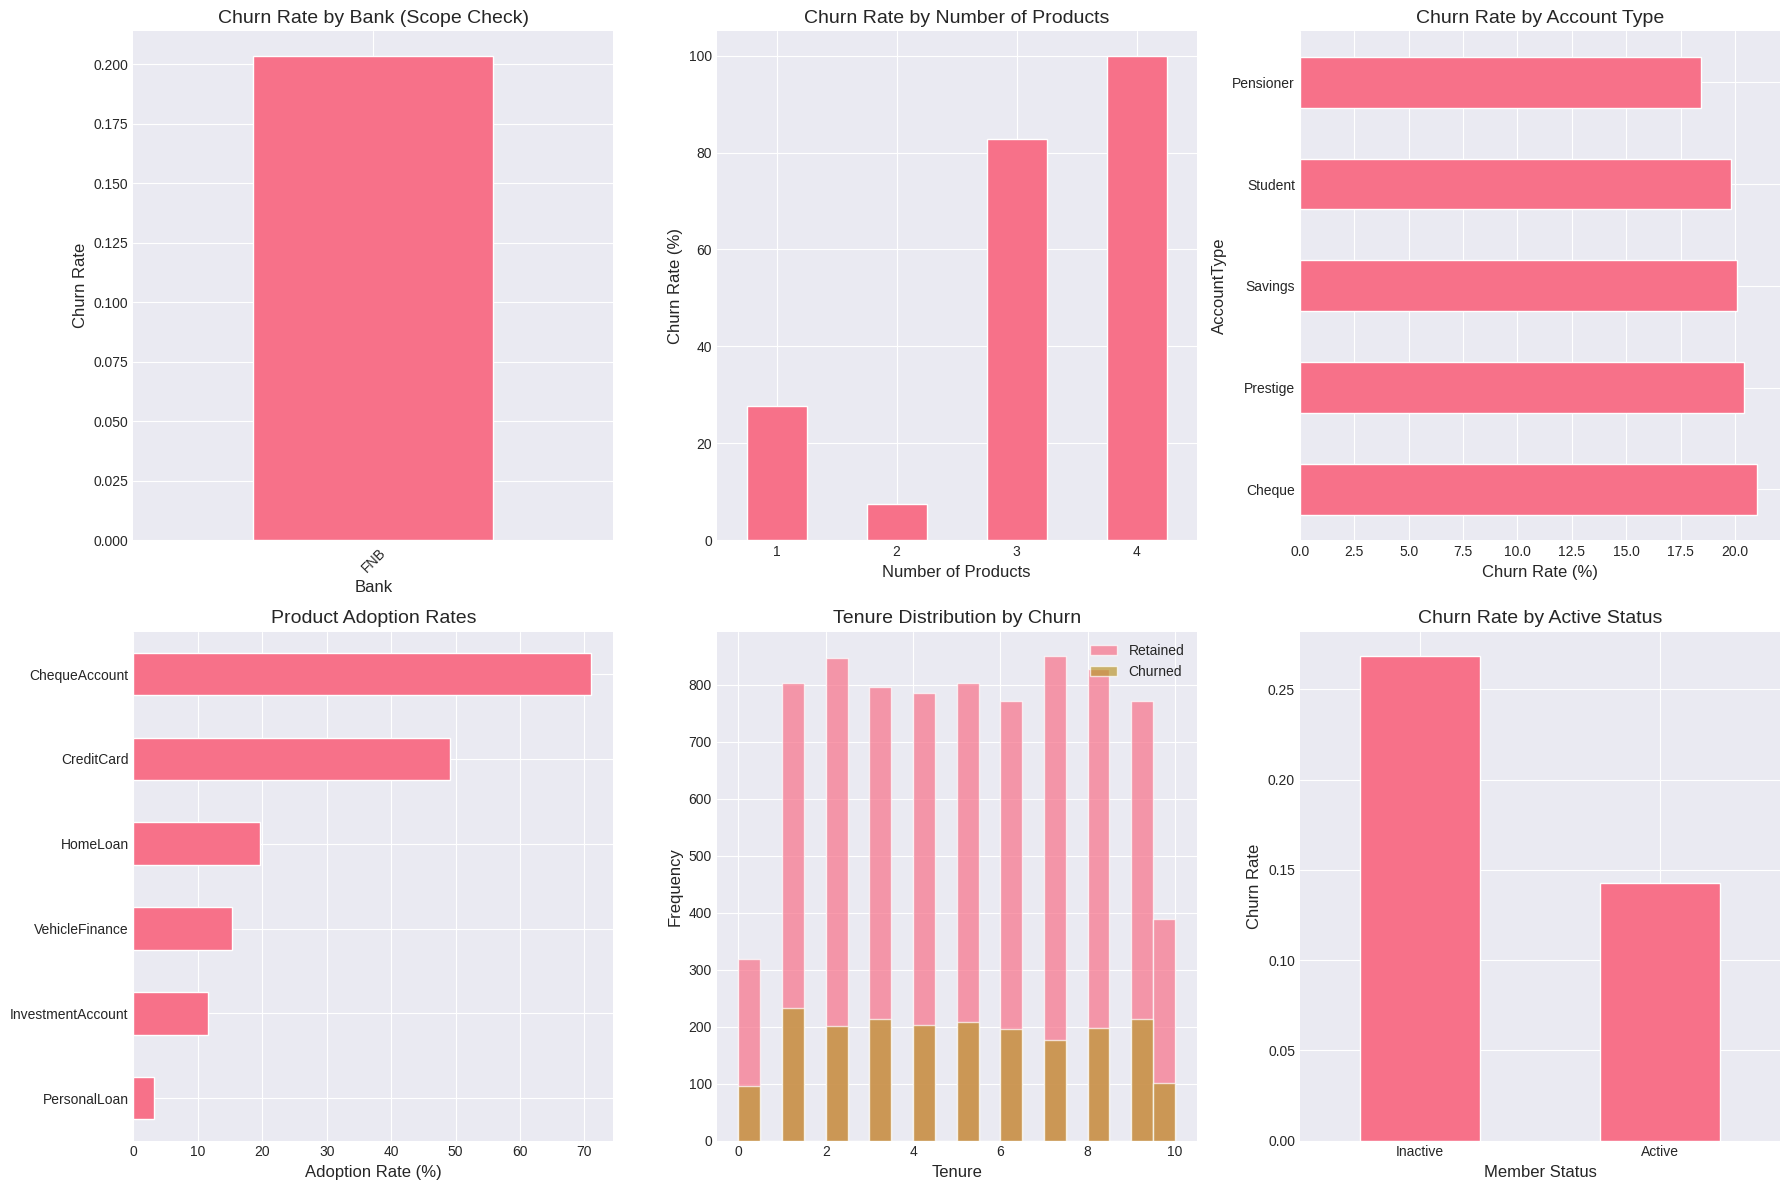

In [13]:
# -----------------------------
# Section 13. Banking products and service profile
# -----------------------------
# This section explores churn across banking attributes and product ownership.
# It highlights relationship depth indicators such as product count, tenure, and active status.

print("\n" + "=" * 80)                                               # Section header
print("BANKING PRODUCTS ANALYSIS")
print("=" * 80)

# Churn rate by bank (scope check for a single-bank dataset)
print("\nChurn rate by bank (scope check):")                          # Confirms dataset is restricted to FNB
bank_analysis = df.groupby("Bank").agg({                              # Aggregate churn and product depth by bank
    "Churned": ["mean", "count"],                                     # Churn rate and sample size
    "NumOfProducts": "mean"                                           # Average product count
}).round(3)

bank_analysis.columns = ["Churn_Rate", "Count", "Avg_Products"]        # Flatten column names
bank_analysis["Churn_Rate_%"] = (bank_analysis["Churn_Rate"] * 100).round(2)  # Convert to percentage
bank_analysis = bank_analysis.sort_values("Churn_Rate_%", ascending=False)    # Sort by churn rate
print(bank_analysis)                                                   # Display summary

# Churn rate by number of products
print("\nChurn rate by number of products:")                          # Product depth vs churn view
product_churn = df.groupby("NumOfProducts")["Churned"].agg(["mean", "count"])  # Mean churn and sample size
product_churn["churn_rate_%"] = (product_churn["mean"] * 100).round(2)         # Convert to percentage
print(product_churn[["count", "churn_rate_%"]])                        # Print table

# Churn rate by account type
print("\nChurn rate by account type:")                                # Account segmentation
account_churn = df.groupby("AccountType")["Churned"].agg(["mean", "count"])    # Mean churn and sample size
account_churn["churn_rate_%"] = (account_churn["mean"] * 100).round(2)         # Convert to percentage
account_churn = account_churn.sort_values("churn_rate_%", ascending=False)     # Sort by churn exposure
print(account_churn[["count", "churn_rate_%"]])                        # Print table

# Churn rate by product ownership flags
product_cols = [                                                      # Product ownership indicators
    "HasChequeAccount", "HasCreditCard", "HasPersonalLoan",
    "HasHomeLoan", "HasVehicleFinance", "HasInvestmentAccount"
]

print("\nChurn rate by product ownership:")                            # Product-level churn comparison
for col in product_cols:
    churn_with = df[df[col] == 1]["Churned"].mean()                   # Churn rate among owners
    churn_without = df[df[col] == 0]["Churned"].mean()                # Churn rate among non-owners
    print(f"{col}: With={churn_with:.2%}, Without={churn_without:.2%}")  # Print comparison

# Visualisations: churn segments + adoption + tenure + active status
fig, axes = plt.subplots(2, 3, figsize=(18, 12))                      # Create 2x3 grid of charts

# 1) Churn by bank (should show only FNB in this project)
bank_churn = df.groupby("Bank")["Churned"].mean().sort_values(ascending=False)  # Mean churn per bank
bank_churn.plot(kind="bar", ax=axes[0, 0])                            # Bar chart
axes[0, 0].set_xlabel("Bank")                                         # Axis label
axes[0, 0].set_ylabel("Churn Rate")                                   # Axis label
axes[0, 0].set_title("Churn Rate by Bank (Scope Check)")              # Plot title
axes[0, 0].tick_params(axis="x", rotation=45)                         # Rotate labels

# 2) Churn by number of products
product_churn["churn_rate_%"].plot(kind="bar", ax=axes[0, 1])          # Bar chart for churn percent
axes[0, 1].set_xlabel("Number of Products")                            # Axis label
axes[0, 1].set_ylabel("Churn Rate (%)")                                # Axis label
axes[0, 1].set_title("Churn Rate by Number of Products")               # Plot title
axes[0, 1].tick_params(axis="x", rotation=0)                           # Keep labels horizontal

# 3) Churn by account type
account_churn["churn_rate_%"].plot(kind="barh", ax=axes[0, 2])         # Horizontal bar chart
axes[0, 2].set_xlabel("Churn Rate (%)")                                # Axis label
axes[0, 2].set_title("Churn Rate by Account Type")                     # Plot title

# 4) Product adoption rates
product_adoption = {col.replace("Has", ""): df[col].mean() * 100 for col in product_cols}  # Adoption percent
pd.Series(product_adoption).sort_values().plot(kind="barh", ax=axes[1, 0])                 # Sorted barh chart
axes[1, 0].set_xlabel("Adoption Rate (%)")                               # Axis label
axes[1, 0].set_title("Product Adoption Rates")                            # Plot title

# 5) Tenure distribution by churn
axes[1, 1].hist(df_retained["Tenure"], bins=20, alpha=0.7, label="Retained")  # Tenure for retained
axes[1, 1].hist(df_churned["Tenure"], bins=20, alpha=0.7, label="Churned")    # Tenure for churned
axes[1, 1].set_xlabel("Tenure")                                          # Axis label
axes[1, 1].set_ylabel("Frequency")                                       # Axis label
axes[1, 1].set_title("Tenure Distribution by Churn")                      # Plot title
axes[1, 1].legend()                                                      # Legend

# 6) Churn by active member status
active_churn = df.groupby("IsActiveMember")["Churned"].mean()            # Mean churn for active vs inactive
active_churn.index = ["Inactive", "Active"]                              # Rename index for clarity
active_churn.plot(kind="bar", ax=axes[1, 2])                             # Bar chart
axes[1, 2].set_xlabel("Member Status")                                   # Axis label
axes[1, 2].set_ylabel("Churn Rate")                                      # Axis label
axes[1, 2].set_title("Churn Rate by Active Status")                      # Plot title
axes[1, 2].tick_params(axis="x", rotation=0)                             # Keep labels horizontal

plt.tight_layout()                                                       # Prevent overlap
plt.savefig("eda_banking_products.png", dpi=300, bbox_inches="tight")     # Save figure for GitHub reuse
print("\nSaved: eda_banking_products.png")                                # Confirmation message
plt.show()                                                                # Display in Colab

## Section 14. Digital Banking and Service Interaction Analysis

This section evaluates customer engagement through digital channels and service touchpoints.  
In modern retail banking, churn is often influenced by how customers interact with the bank across mobile apps, internet banking, branches, ATMs, and support channels.

The analysis focuses on:
- Digital adoption rates for mobile and internet banking.
- Churn rate differences between users and non-users of each digital channel.
- Physical channel behaviour through branch visits and ATM transactions.
- Service friction indicators such as customer service calls and complaints.

The goal is to understand whether churn is linked to low digital adoption, high physical reliance, or increased service issues, and to identify engagement variables that may be strong predictors for modelling.


DIGITAL BANKING ANALYSIS

Digital banking adoption:
Mobile banking adoption: 80.6%
Internet banking adoption: 70.0%

Churn rate by digital channel usage:
Mobile Banking: Users=20.39%, Non-users=20.27%
Internet Banking: Users=19.75%, Non-users=21.82%

Branch and ATM usage:
Average monthly branch visits: 1.49
Average monthly ATM transactions: 8.03

Saved: eda_digital_banking.png


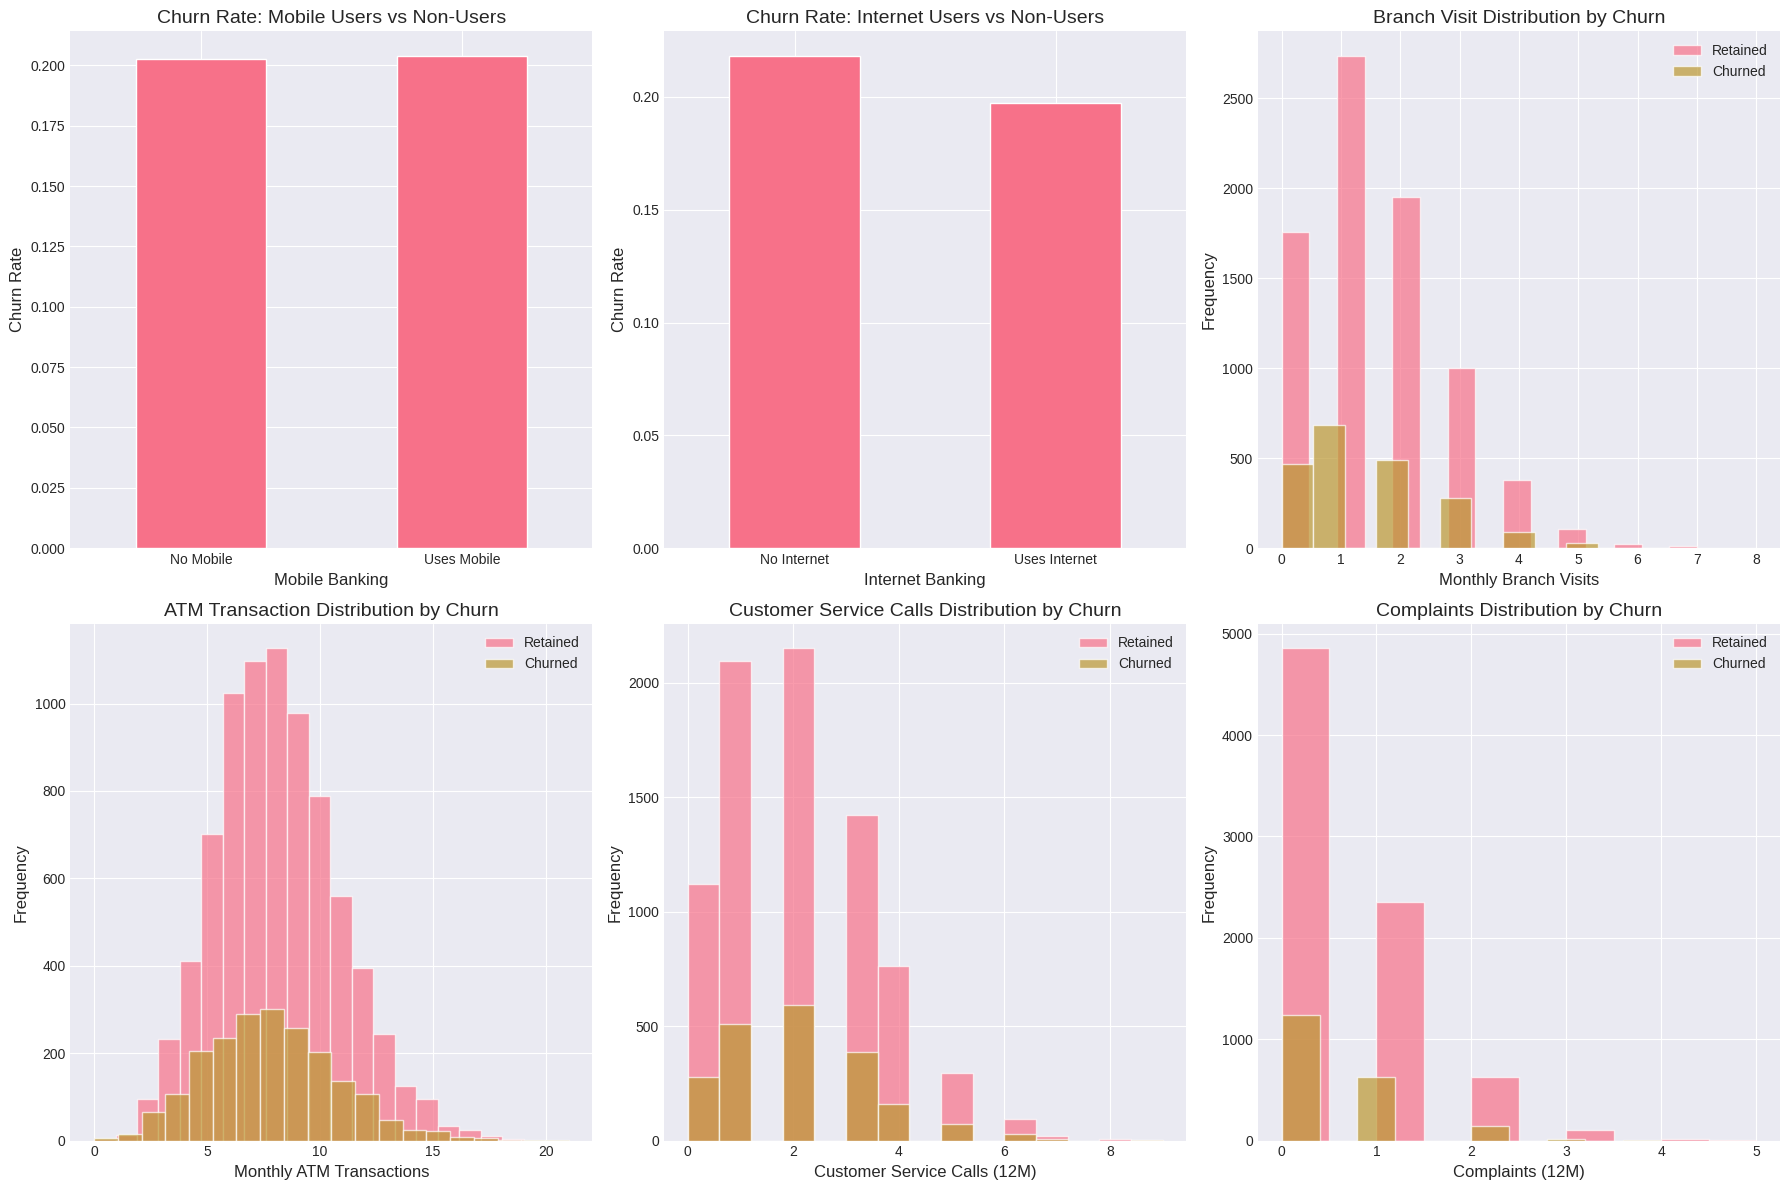

In [14]:
# -----------------------------
# Section 14. Digital banking and service interaction
# -----------------------------
# This section evaluates digital adoption and customer interaction signals
# such as branch/ATM usage, service calls, and complaints.

print("\n" + "=" * 80)                                               # Section header
print("DIGITAL BANKING ANALYSIS")
print("=" * 80)

# Digital adoption rates
print("\nDigital banking adoption:")                                   # Channel adoption context
print(f"Mobile banking adoption: {df['UsesMobileBanking'].mean():.1%}")    # Share of customers using mobile banking
print(f"Internet banking adoption: {df['UsesInternetBanking'].mean():.1%}") # Share of customers using internet banking

# Churn rate by channel usage
print("\nChurn rate by digital channel usage:")                        # Compare churn for users vs non-users
digital_features = {                                                   # Map labels to dataset columns
    "Mobile Banking": "UsesMobileBanking",
    "Internet Banking": "UsesInternetBanking"
}

for channel_name, col in digital_features.items():
    churn_users = df[df[col] == 1]["Churned"].mean()                   # Churn rate among channel users
    churn_non_users = df[df[col] == 0]["Churned"].mean()               # Churn rate among non-users
    print(f"{channel_name}: Users={churn_users:.2%}, Non-users={churn_non_users:.2%}")  # Print comparison

# Branch and ATM usage levels
print("\nBranch and ATM usage:")                                       # Physical channel behaviour context
print(f"Average monthly branch visits: {df['MonthlyBranchVisits'].mean():.2f}")          # Mean monthly branch visits
print(f"Average monthly ATM transactions: {df['MonthlyATMTransactions'].mean():.2f}")    # Mean monthly ATM transactions

# Visualisations: digital adoption, channel reliance, and service friction
fig, axes = plt.subplots(2, 3, figsize=(18, 12))                       # Create a 2x3 grid of plots

# 1) Mobile banking users vs non-users
mobile_churn = df.groupby("UsesMobileBanking")["Churned"].mean()       # Mean churn by mobile usage flag
mobile_churn.index = ["No Mobile", "Uses Mobile"]                      # Improve label readability
mobile_churn.plot(kind="bar", ax=axes[0, 0])                           # Bar chart
axes[0, 0].set_xlabel("Mobile Banking")                                 # Axis label
axes[0, 0].set_ylabel("Churn Rate")                                     # Axis label
axes[0, 0].set_title("Churn Rate: Mobile Users vs Non-Users")           # Plot title
axes[0, 0].tick_params(axis="x", rotation=0)                            # Keep labels horizontal

# 2) Internet banking users vs non-users
internet_churn = df.groupby("UsesInternetBanking")["Churned"].mean()   # Mean churn by internet usage flag
internet_churn.index = ["No Internet", "Uses Internet"]                # Improve label readability
internet_churn.plot(kind="bar", ax=axes[0, 1])                         # Bar chart
axes[0, 1].set_xlabel("Internet Banking")                               # Axis label
axes[0, 1].set_ylabel("Churn Rate")                                     # Axis label
axes[0, 1].set_title("Churn Rate: Internet Users vs Non-Users")         # Plot title
axes[0, 1].tick_params(axis="x", rotation=0)                            # Keep labels horizontal

# 3) Branch visits distribution by churn
axes[0, 2].hist(df_retained["MonthlyBranchVisits"], bins=15, alpha=0.7, label="Retained")  # Retained branch visits
axes[0, 2].hist(df_churned["MonthlyBranchVisits"], bins=15, alpha=0.7, label="Churned")    # Churned branch visits
axes[0, 2].set_xlabel("Monthly Branch Visits")                          # Axis label
axes[0, 2].set_ylabel("Frequency")                                      # Axis label
axes[0, 2].set_title("Branch Visit Distribution by Churn")              # Plot title
axes[0, 2].legend()                                                     # Legend

# 4) ATM transactions distribution by churn
axes[1, 0].hist(df_retained["MonthlyATMTransactions"], bins=20, alpha=0.7, label="Retained")  # Retained ATM usage
axes[1, 0].hist(df_churned["MonthlyATMTransactions"], bins=20, alpha=0.7, label="Churned")    # Churned ATM usage
axes[1, 0].set_xlabel("Monthly ATM Transactions")                       # Axis label
axes[1, 0].set_ylabel("Frequency")                                      # Axis label
axes[1, 0].set_title("ATM Transaction Distribution by Churn")           # Plot title
axes[1, 0].legend()                                                     # Legend

# 5) Customer service calls distribution by churn
axes[1, 1].hist(df_retained["CustomerServiceCalls_12M"], bins=15, alpha=0.7, label="Retained")  # Retained service calls
axes[1, 1].hist(df_churned["CustomerServiceCalls_12M"], bins=15, alpha=0.7, label="Churned")    # Churned service calls
axes[1, 1].set_xlabel("Customer Service Calls (12M)")                   # Axis label
axes[1, 1].set_ylabel("Frequency")                                      # Axis label
axes[1, 1].set_title("Customer Service Calls Distribution by Churn")    # Plot title
axes[1, 1].legend()                                                     # Legend

# 6) Complaints distribution by churn
axes[1, 2].hist(df_retained["Complaints_12M"], bins=10, alpha=0.7, label="Retained")  # Retained complaints
axes[1, 2].hist(df_churned["Complaints_12M"], bins=10, alpha=0.7, label="Churned")    # Churned complaints
axes[1, 2].set_xlabel("Complaints (12M)")                               # Axis label
axes[1, 2].set_ylabel("Frequency")                                     # Axis label
axes[1, 2].set_title("Complaints Distribution by Churn")               # Plot title
axes[1, 2].legend()                                                    # Legend

plt.tight_layout()                                                     # Prevent overlap
plt.savefig("eda_digital_banking.png", dpi=300, bbox_inches="tight")   # Save for GitHub/README reuse
print("\nSaved: eda_digital_banking.png")                              # Confirmation message
plt.show()                                                             # Display in Colab

## Section 15. Demographic and Socioeconomic Segmentation

This section analyses churn patterns across key demographic and socioeconomic attributes.  
These variables often capture differences in customer needs, service expectations, product suitability, and communication preferences.

The analysis focuses on:
- Gender churn rates and a chi-square test to assess statistical association.
- Education level churn rates to understand churn exposure across qualification bands.
- Employment type churn rates to identify segments with potentially higher financial volatility.
- Preferred language and communication channel, which can signal service fit and engagement effectiveness.

The goal is to identify demographic segments with elevated churn risk and highlight variables that may contribute predictive value in the churn model.


DEMOGRAPHIC ANALYSIS

Gender analysis:
        count  churn_rate_%
Gender                     
Female   4543         25.07
Male     5457         16.46

Chi-square test (Gender vs Churn): χ²=112.919, p-value=0.0000

Education level:
                count  churn_rate_%
EducationLevel                     
Matric           3491         20.94
Diploma          2484         20.29
Degree           1497         20.24
No Matric        1557         20.23
Postgraduate      971         18.95

Employment type:
                count  churn_rate_%
EmploymentType                     
Student           468         21.58
Pensioner        1010         21.19
Self-Employed    1492         20.98
Employed         5499         20.29
Unemployed       1531         19.14

Preferred language (top 5 by customer count):
                   count  churn_rate_%
PreferredLanguage                     
English             2511         19.91
Afrikaans           1970         21.68
isiZulu             1565         21.21
isi

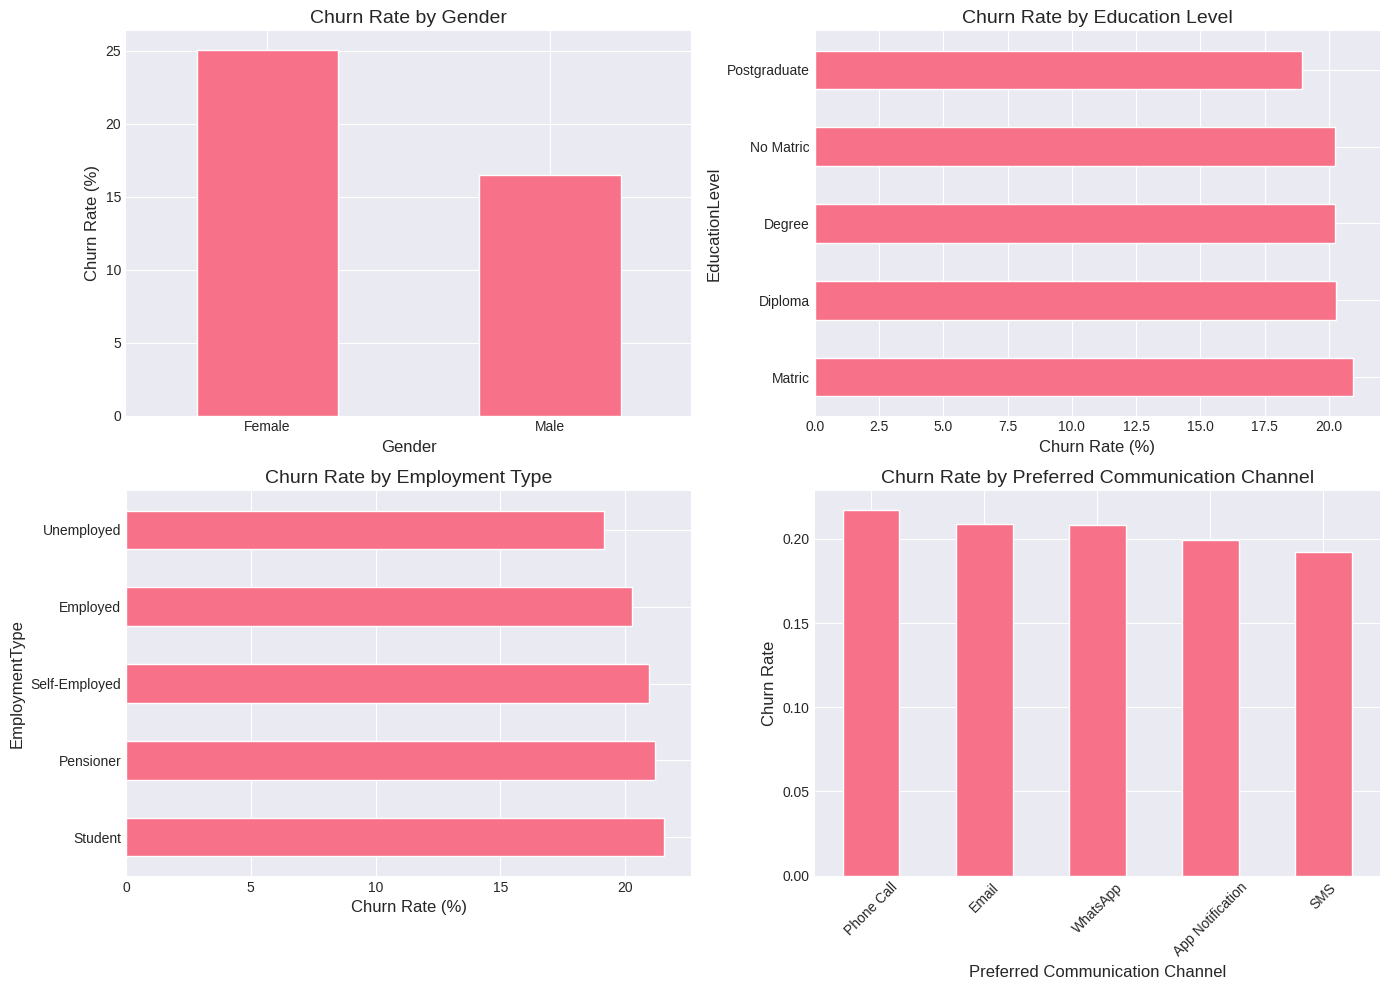

In [15]:
# -----------------------------
# Section 15. Demographic analysis
# -----------------------------
# This section explores churn differences across demographic and socioeconomic features
# and uses a chi-square test for categorical association where relevant.

print("\n" + "=" * 80)                                               # Section header
print("DEMOGRAPHIC ANALYSIS")
print("=" * 80)

# Gender churn analysis
print("\nGender analysis:")                                           # Gender-based churn view
gender_churn = df.groupby("Gender")["Churned"].agg(["mean", "count"])  # Mean churn and sample size
gender_churn["churn_rate_%"] = (gender_churn["mean"] * 100).round(2)  # Convert to percentage
print(gender_churn[["count", "churn_rate_%"]])                        # Print churn table

# Chi-square test: Gender vs Churn
gender_contingency = pd.crosstab(df["Gender"], df["Churned"])         # Contingency table for chi-square
chi2, p_value, dof, expected = chi2_contingency(gender_contingency)   # Chi-square test of independence
print(f"\nChi-square test (Gender vs Churn): χ²={chi2:.3f}, p-value={p_value:.4f}")  # Report statistical output

# Education level churn analysis
print("\nEducation level:")                                           # Education segmentation view
edu_churn = df.groupby("EducationLevel")["Churned"].agg(["mean", "count"])  # Mean churn and sample size
edu_churn["churn_rate_%"] = (edu_churn["mean"] * 100).round(2)        # Convert to percentage
edu_churn = edu_churn.sort_values("churn_rate_%", ascending=False)    # Sort by churn exposure
print(edu_churn[["count", "churn_rate_%"]])                           # Print churn table

# Employment type churn analysis
print("\nEmployment type:")                                           # Employment segmentation view
emp_churn = df.groupby("EmploymentType")["Churned"].agg(["mean", "count"])  # Mean churn and sample size
emp_churn["churn_rate_%"] = (emp_churn["mean"] * 100).round(2)        # Convert to percentage
emp_churn = emp_churn.sort_values("churn_rate_%", ascending=False)    # Sort by churn exposure
print(emp_churn[["count", "churn_rate_%"]])                           # Print churn table

# Preferred language churn analysis (top 5 by volume)
print("\nPreferred language (top 5 by customer count):")              # Limit to most common languages
lang_churn = df.groupby("PreferredLanguage")["Churned"].agg(["mean", "count"])  # Mean churn and sample size
lang_churn["churn_rate_%"] = (lang_churn["mean"] * 100).round(2)      # Convert to percentage
lang_churn = lang_churn.sort_values("count", ascending=False).head(5) # Keep top 5 by sample size
print(lang_churn[["count", "churn_rate_%"]])                          # Print churn table

# Visualisations: demographics and communication preferences
fig, axes = plt.subplots(2, 2, figsize=(14, 10))                      # Create 2x2 grid

# 1) Churn rate by gender
gender_churn["churn_rate_%"].plot(kind="bar", ax=axes[0, 0])          # Bar chart for churn percent
axes[0, 0].set_xlabel("Gender")                                       # Axis label
axes[0, 0].set_ylabel("Churn Rate (%)")                               # Axis label
axes[0, 0].set_title("Churn Rate by Gender")                          # Plot title
axes[0, 0].tick_params(axis="x", rotation=0)                          # Keep labels horizontal

# 2) Churn rate by education level
edu_churn["churn_rate_%"].plot(kind="barh", ax=axes[0, 1])            # Horizontal bar chart
axes[0, 1].set_xlabel("Churn Rate (%)")                               # Axis label
axes[0, 1].set_title("Churn Rate by Education Level")                 # Plot title

# 3) Churn rate by employment type
emp_churn["churn_rate_%"].plot(kind="barh", ax=axes[1, 0])            # Horizontal bar chart
axes[1, 0].set_xlabel("Churn Rate (%)")                               # Axis label
axes[1, 0].set_title("Churn Rate by Employment Type")                 # Plot title

# 4) Churn rate by preferred communication channel
comm_churn = df.groupby("PreferredCommChannel")["Churned"].mean().sort_values(ascending=False)  # Mean churn by comm channel
comm_churn.plot(kind="bar", ax=axes[1, 1])                            # Bar chart
axes[1, 1].set_xlabel("Preferred Communication Channel")              # Axis label
axes[1, 1].set_ylabel("Churn Rate")                                   # Axis label
axes[1, 1].set_title("Churn Rate by Preferred Communication Channel") # Plot title
axes[1, 1].tick_params(axis="x", rotation=45)                         # Rotate labels for readability

plt.tight_layout()                                                    # Prevent overlap
plt.savefig("eda_demographics.png", dpi=300, bbox_inches="tight")     # Save figure for GitHub/README reuse
print("\nSaved: eda_demographics.png")                                 # Confirmation message
plt.show()                                                            # Display in Colab

## Section 16. Correlation Analysis

This section examines linear relationships between numerical features and customer churn.  
The objective is to identify variables that show meaningful positive or negative association with churn and to highlight candidates for feature selection in downstream modeling.

The analysis includes:
- A full correlation matrix across all numerical variables.
- A ranked view of features most strongly correlated with churn.
- Visual diagnostics using a labelled heatmap and a churn-focused correlation bar chart.

Correlation does not imply causation, but these relationships provide strong guidance for feature engineering and model prioritisation.


CORRELATION ANALYSIS

Top 15 features correlated with churn:
Churned                     1.00
HasPersonalLoan             0.30
Age                         0.28
HasPremiumBanking           0.15
Balance_ZAR                 0.12
FinancialWellnessScore      0.07
AnnualSalary_ZAR            0.01
MonthlySalary_ZAR           0.01
HasInvestmentAccount        0.01
CustomerServiceCalls_12M    0.00
UsesMobileBanking           0.00
HasHomeLoan                -0.00
HasVehicleFinance          -0.00
MonthlyBranchVisits        -0.01
HasCreditCard_Flag         -0.01
Complaints_12M             -0.01
Name: Churned, dtype: float64

Saved: eda_correlation_analysis.png


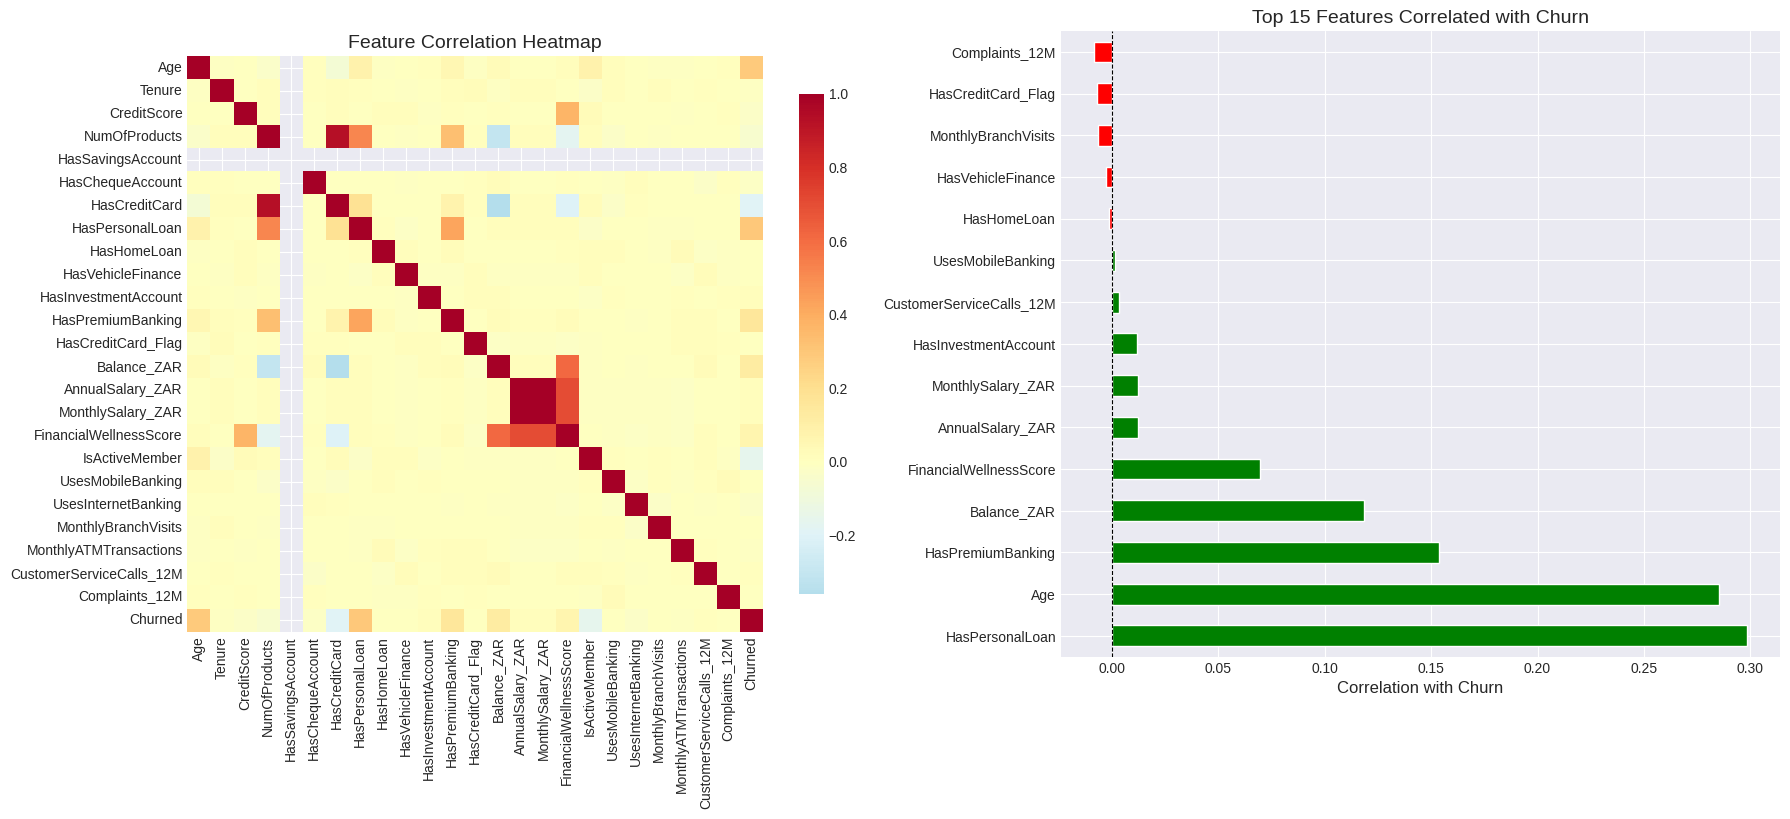

In [16]:
# -----------------------------
# Section 16. Correlation analysis
# -----------------------------
# This section evaluates linear relationships between numerical features and churn
# and visualises them using a labelled correlation matrix and ranked bar chart.

print("\n" + "=" * 80)                                                # Section header
print("CORRELATION ANALYSIS")
print("=" * 80)

# Select numerical columns only
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()  # All numeric features
numerical_cols = [col for col in numerical_cols if col not in ["RowNumber", "CustomerId"]]  # Remove identifiers

# Compute correlation matrix
corr_matrix = df[numerical_cols].corr()                               # Pearson correlation matrix

# Rank features by correlation with churn
churn_corr = corr_matrix["Churned"].sort_values(ascending=False)      # Sort correlations
print("\nTop 15 features correlated with churn:")
print(churn_corr.head(16).round(3))                                   # Include Churned itself for reference

# Create visualisations
fig, axes = plt.subplots(1, 2, figsize=(18, 8))                       # Two-panel layout

# Full correlation heatmap with labels
sns.heatmap(
    corr_matrix,
    cmap="RdYlBu_r",
    center=0,
    square=True,
    xticklabels=corr_matrix.columns,                                  # Explicit x-axis labels
    yticklabels=corr_matrix.columns,                                  # Explicit y-axis labels
    cbar_kws={"shrink": 0.8},
    ax=axes[0]
)
axes[0].set_title("Feature Correlation Heatmap")                      # Heatmap title
axes[0].tick_params(axis="x", rotation=90)                            # Rotate labels for readability
axes[0].tick_params(axis="y", rotation=0)

# Bar plot: top correlations with churn (excluding churn itself)
churn_corr_plot = churn_corr.drop("Churned").head(15)                 # Top 15 correlated features
bar_colors = ["red" if x < 0 else "green" for x in churn_corr_plot]   # Color by sign of correlation

churn_corr_plot.plot(kind="barh", ax=axes[1], color=bar_colors)       # Horizontal bar chart
axes[1].set_xlabel("Correlation with Churn")                          # Axis label
axes[1].set_title("Top 15 Features Correlated with Churn")            # Chart title
axes[1].axvline(x=0, color="black", linestyle="--", linewidth=0.8)    # Zero reference line

plt.tight_layout()                                                     # Prevent overlap
plt.savefig("eda_correlation_analysis.png", dpi=300, bbox_inches="tight")  # Save for GitHub
print("\nSaved: eda_correlation_analysis.png")                         # Confirmation message
plt.show()                                                             # Display in notebook

## Section 17. Executive Summary

This section consolidates the main findings from the EDA into a single, interview-ready narrative.  
The aim is to translate exploratory outputs into clear business insights that an FNB stakeholder would understand.

The summary covers:
- Dataset size and overall churn level.
- The strongest churn signals observed in age, geography, financial position, credit profile, product depth, and engagement.
- Practical segmentation insights that can inform retention strategy and guide feature selection for modelling.

The output is designed to read like a short internal briefing note rather than a technical dump.

In [17]:
# -----------------------------
# Section 17. Executive summary
# -----------------------------
# This section prints a concise EDA summary that reads like a stakeholder briefing
# and highlights the strongest churn signals observed in the dataset.

print("\n" + "=" * 80)                                                # Section header
print("EXECUTIVE SUMMARY")
print("=" * 80)

# Dataset overview
total_customers = len(df)                                             # Total number of customers
churn_rate = df["Churned"].mean()                                      # Overall churn rate

print("\nDATASET OVERVIEW:")                                           # Overview heading
print(f"Total customers: {total_customers:,}")                         # Total customers
print(f"Churned: {df_churned.shape[0]:,} ({churn_rate:.1%})")          # Churn count and rate
print(f"Retained: {df_retained.shape[0]:,} ({(1 - churn_rate):.1%})")  # Retained count and rate

print("\nKEY FINDINGS:")                                               # Findings heading

# 1) Age insight
age_diff = df_churned["Age"].mean() - df_retained["Age"].mean()        # Mean age difference
highest_churn_age_group = df.groupby("AgeGroup")["Churned"].mean().idxmax() if "AgeGroup" in df.columns else "AgeGroup not created"
print("\n1. Age:")                                                     # Finding label
print(f"Churned customers are {abs(age_diff):.1f} years {'older' if age_diff > 0 else 'younger'} on average")  # Age direction
print(f"Highest churn age group: {highest_churn_age_group}")           # Highest risk age segment

# 2) Geographic insight
highest_churn_province = df.groupby("Province")["Churned"].mean().idxmax()  # Province with highest churn
lowest_churn_province = df.groupby("Province")["Churned"].mean().idxmin()   # Province with lowest churn
print("\n2. Geography:")                                               # Finding label
print(f"Highest churn province: {highest_churn_province}")             # Top churn province
print(f"Lowest churn province: {lowest_churn_province}")               # Lowest churn province

# 3) Financial insight
balance_diff = df_churned["Balance_ZAR"].mean() - df_retained["Balance_ZAR"].mean()  # Mean balance difference
zero_balance_churn = df[df["Balance_ZAR"] == 0]["Churned"].mean() if (df["Balance_ZAR"] == 0).any() else np.nan  # Churn among zero-balance customers
print("\n3. Financial position:")                                      # Finding label
print(f"Churned customers have R{abs(balance_diff):,.2f} {'higher' if balance_diff > 0 else 'lower'} average balance")  # Balance direction
print(f"Zero-balance churn rate: {zero_balance_churn:.1%}")            # Zero-balance churn exposure

# 4) Credit insight
credit_diff = df_churned["CreditScore"].mean() - df_retained["CreditScore"].mean()  # Mean credit score difference
worst_credit_rating = df.groupby("CreditRating")["Churned"].mean().idxmax() if "CreditRating" in df.columns else "CreditRating not available"
print("\n4. Credit profile:")                                          # Finding label
print(f"Churned customers have {abs(credit_diff):.0f} points {'higher' if credit_diff > 0 else 'lower'} credit score")  # Credit direction
print(f"Highest churn credit rating: {worst_credit_rating}")           # Highest risk credit band

# 5) Product insight
product_churn = df.groupby("NumOfProducts")["Churned"].mean()          # Churn rate by product count
worst_products = product_churn.idxmax()                                # Product count with highest churn
print("\n5. Products and relationship depth:")                         # Finding label
print(f"Highest churn occurs at {worst_products} products ({product_churn.max():.1%} churn rate)")  # Product depth insight

active_retention = (1 - df[df["IsActiveMember"] == 1]["Churned"].mean()) * 100 if (df["IsActiveMember"] == 1).any() else np.nan  # Retention among active members
print(f"Active members retention: {active_retention:.1f}%")            # Active member retention estimate

# 6) Digital and service insight
mobile_non_users_churn = df[df["UsesMobileBanking"] == 0]["Churned"].mean() if (df["UsesMobileBanking"] == 0).any() else np.nan  # Churn among non-mobile users
mobile_users_churn = df[df["UsesMobileBanking"] == 1]["Churned"].mean() if (df["UsesMobileBanking"] == 1).any() else np.nan      # Churn among mobile users
mobile_impact = mobile_non_users_churn - mobile_users_churn if pd.notna(mobile_non_users_churn) and pd.notna(mobile_users_churn) else np.nan  # Difference in churn

high_complaints_churn = df[df["Complaints_12M"] > 0]["Churned"].mean() if (df["Complaints_12M"] > 0).any() else np.nan  # Churn among customers with complaints
print("\n6. Digital banking and service friction:")                    # Finding label
print(f"Non-mobile users have {mobile_impact*100:.1f}% higher churn rate") if pd.notna(mobile_impact) else print("Mobile impact: insufficient data")  # Mobile adoption effect
print(f"Customers with complaints churn rate: {high_complaints_churn:.1%}") if pd.notna(high_complaints_churn) else print("Complaints churn: insufficient data")  # Complaint effect

# 7) Bank insight (scope check for multi-bank datasets)
if "Bank" in df.columns and df["Bank"].nunique() > 1:                  # Only relevant if multiple banks exist
    worst_bank = df.groupby("Bank")["Churned"].mean().idxmax()         # Highest churn bank
    best_bank = df.groupby("Bank")["Churned"].mean().idxmin()          # Lowest churn bank
    print("\n7. Banking context:")                                     # Finding label
    print(f"Highest churn bank: {worst_bank}")                         # Highest churn bank
    print(f"Lowest churn bank: {best_bank}")                           # Lowest churn bank
else:
    print("\n7. Banking context:")                                     # Finding label
    print("Dataset is scoped to a single bank (FNB), so bank-to-bank comparison is not applicable")  # Scope note


EXECUTIVE SUMMARY

DATASET OVERVIEW:
Total customers: 10,000
Churned: 2,037 (20.4%)
Retained: 7,963 (79.6%)

KEY FINDINGS:

1. Age:
Churned customers are 7.4 years older on average
Highest churn age group: 46-55

2. Geography:
Highest churn province: Limpopo
Lowest churn province: KwaZulu-Natal

3. Financial position:
Churned customers have R376,446.47 higher average balance
Zero-balance churn rate: 13.8%

4. Credit profile:
Churned customers have 7 points lower credit score
Highest churn credit rating: Poor

5. Products and relationship depth:
Highest churn occurs at 4 products (100.0% churn rate)
Active members retention: 85.7%

6. Digital banking and service friction:
Non-mobile users have -0.1% higher churn rate
Customers with complaints churn rate: 20.5%

7. Banking context:
Dataset is scoped to a single bank (FNB), so bank-to-bank comparison is not applicable


## Advanced EDA. Part 2. Overview

This notebook extends the baseline EDA by adding segmentation and risk perspectives that align with how a bank would plan retention strategy.

It covers:
- Customer segmentation using an RFM-style approach.
- Rule-based churn risk profiling and lift.
- Cohort analysis by tenure bands.
- A simple Customer Lifetime Value proxy and value-at-risk.
- Statistical tests to validate whether observed differences are meaningful.
- A short business insights report to translate results into actions.

The analyses are designed to produce interpretable artefacts that can be discussed in interviews and reused in a model narrative.

## Section A. Setup and Data Load

This section imports the required libraries, sets visual defaults, loads the dataset, and prepares churned vs retained subsets for comparisons.

In [18]:
import pandas as pd                                                     # Data loading and tabular analysis
import numpy as np                                                      # Numerical operations
import matplotlib.pyplot as plt                                         # Plotting
import seaborn as sns                                                   # Statistical plotting
from scipy import stats                                                 # Statistical tests
from sklearn.preprocessing import StandardScaler                         # Feature scaling for clustering
from sklearn.cluster import KMeans                                       # KMeans clustering
import warnings                                                         # Warning control
warnings.filterwarnings("ignore")                                        # Reduce noise in notebook output

plt.style.use("seaborn-v0_8-whitegrid")                                  # Consistent plot style
sns.set_palette("Set2")                                                  # Consistent colour palette

from pathlib import Path                                                 # Robust file path handling


df_churned = df[df["Churned"] == 1].copy()                               # Subset: churned customers
df_retained = df[df["Churned"] == 0].copy()                              # Subset: retained customers

print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")                 # Quick shape check
print(f"Churn rate: {df['Churned'].mean():.2%}")                         # Baseline churn rate

Rows: 10,000 | Columns: 45
Churn rate: 20.37%


## Section B. Customer Segmentation Using RFM-Style Scoring

This section builds a simple segmentation scheme to group customers by relationship maturity and value proxies.

RFM proxies used here:
- Recency proxy: Tenure (longer tenure implies more embedded relationship).
- Frequency proxy: Number of products.
- Monetary proxy: Balance (in ZAR).

The output includes:
- R, F, M scores.
- A combined RFM segment code.
- A high-level value tier (Low, Medium, High, VIP).
- Churn rate and revenue-at-risk by segment.


CUSTOMER SEGMENTATION (RFM-STYLE)

Customer value segments:
                Count  Churn_Rate  Avg_Balance  Avg_Products  Churn_Rate_%
Customer_Value                                                            
Low Value        1339        0.20   378,215.85          1.43         20.00
Medium Value     6155        0.19 1,465,800.45          1.51         19.00
High Value       2241        0.24 2,395,261.53          1.55         24.00
VIP               265        0.35 2,956,201.64          2.38         35.00

Saved: advanced_eda_segmentation.png


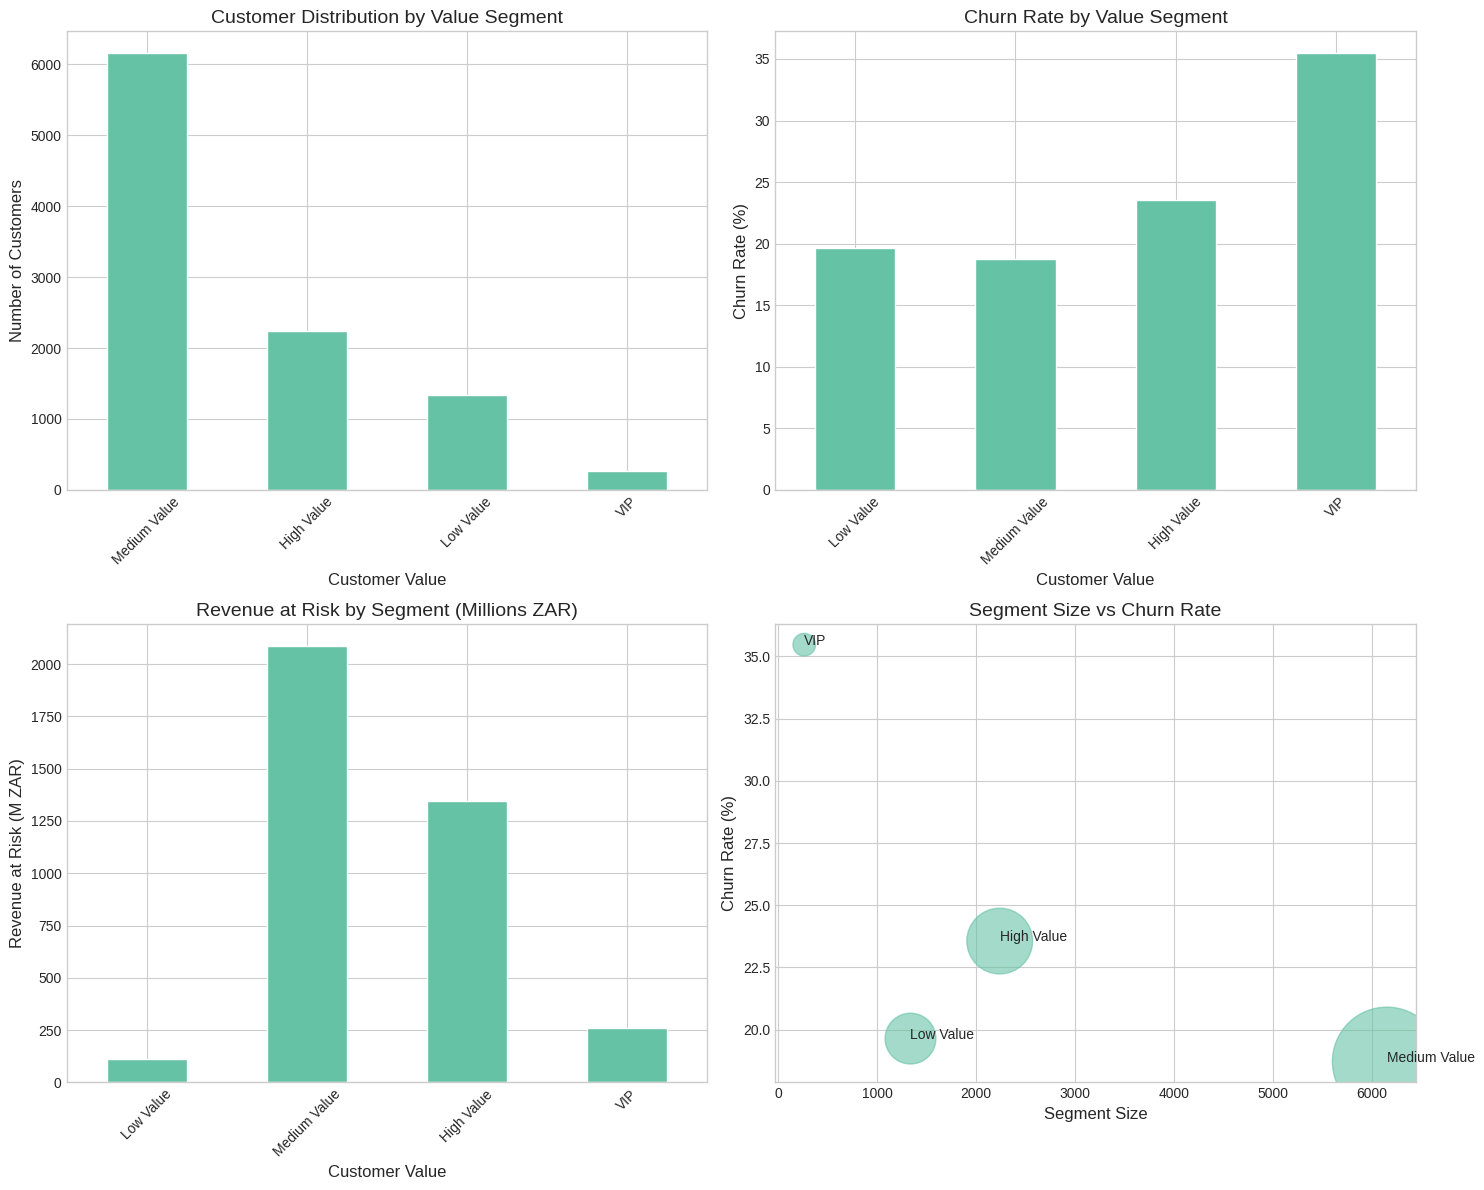

In [19]:
print("\n" + "=" * 80)                                                   # Section header
print("CUSTOMER SEGMENTATION (RFM-STYLE)")
print("=" * 80)

# R score from tenure (quartiles where possible)
try:
    df["R_Score"] = pd.qcut(df["Tenure"], q=4, labels=False, duplicates="drop") + 1  # Tenure quartiles into 1..4
except Exception:
    df["R_Score"] = pd.cut(df["Tenure"], bins=4, labels=False) + 1       # Fallback binning if qcut fails

# F score from product count (fixed bins)
df["F_Score"] = pd.cut(df["NumOfProducts"], bins=[0, 1, 2, 3, 5], labels=False) + 1  # 1..4 based on product depth

# M score from balance (handle heavy zeros by ranking before qcut)
try:
    df["M_Score"] = pd.qcut(df["Balance_ZAR"].rank(method="first"), q=4, labels=False, duplicates="drop") + 1  # Balance quartiles into 1..4
except Exception:
    df["M_Score"] = pd.cut(df["Balance_ZAR"], bins=4, labels=False) + 1   # Fallback binning if qcut fails

# Combine into a segment label
df["RFM_Segment"] = df["R_Score"].astype(str) + df["F_Score"].astype(str) + df["M_Score"].astype(str)  # 3-digit segment code

# Create a value tier from total RFM score
df["Customer_Value"] = pd.cut(
    df["R_Score"].astype(int) + df["F_Score"].astype(int) + df["M_Score"].astype(int),
    bins=[0, 4, 7, 9, 12],
    labels=["Low Value", "Medium Value", "High Value", "VIP"]
)                                                                          # Coarse segmentation for reporting

# Segment summary table
segment_analysis = df.groupby("Customer_Value").agg({
    "Churned": ["count", "mean"],
    "Balance_ZAR": "mean",
    "NumOfProducts": "mean"
}).round(2)                                                                 # Segment size, churn rate, and value proxies
segment_analysis.columns = ["Count", "Churn_Rate", "Avg_Balance", "Avg_Products"]  # Flatten columns for readability
segment_analysis["Churn_Rate_%"] = (segment_analysis["Churn_Rate"] * 100).round(2) # Convert churn rate to %
print("\nCustomer value segments:")                                         # Table heading
print(segment_analysis)                                                     # Print segment table

# Revenue at risk proxy (balance at risk)
df["Revenue_at_Risk"] = df["Balance_ZAR"] * df["Churned"]                   # Balance counted only for churned customers

# Visuals
fig, axes = plt.subplots(2, 2, figsize=(15, 12))                            # 2x2 grid for segmentation visuals

df["Customer_Value"].value_counts().plot(kind="bar", ax=axes[0, 0])         # Segment size distribution
axes[0, 0].set_title("Customer Distribution by Value Segment")
axes[0, 0].set_xlabel("Customer Value")
axes[0, 0].set_ylabel("Number of Customers")
axes[0, 0].tick_params(axis="x", rotation=45)

(df.groupby("Customer_Value")["Churned"].mean() * 100).plot(kind="bar", ax=axes[0, 1])  # Churn rate by segment
axes[0, 1].set_title("Churn Rate by Value Segment")
axes[0, 1].set_xlabel("Customer Value")
axes[0, 1].set_ylabel("Churn Rate (%)")
axes[0, 1].tick_params(axis="x", rotation=45)

(df.groupby("Customer_Value")["Revenue_at_Risk"].sum() / 1_000_000).plot(kind="bar", ax=axes[1, 0])  # Balance at risk by segment
axes[1, 0].set_title("Revenue at Risk by Segment (Millions ZAR)")
axes[1, 0].set_xlabel("Customer Value")
axes[1, 0].set_ylabel("Revenue at Risk (M ZAR)")
axes[1, 0].tick_params(axis="x", rotation=45)

segment_summary = df.groupby("Customer_Value")["Churned"].agg(["count", "mean"])        # Segment size and churn rate
axes[1, 1].scatter(segment_summary["count"], segment_summary["mean"] * 100, s=segment_summary["count"], alpha=0.6)  # Bubble chart
axes[1, 1].set_xlabel("Segment Size")
axes[1, 1].set_ylabel("Churn Rate (%)")
axes[1, 1].set_title("Segment Size vs Churn Rate")

for label in segment_summary.index:
    axes[1, 1].annotate(label, (segment_summary.loc[label, "count"], segment_summary.loc[label, "mean"] * 100))     # Label bubbles

plt.tight_layout()
plt.savefig("advanced_eda_segmentation.png", dpi=300, bbox_inches="tight") # Save figure for GitHub
print("\nSaved: advanced_eda_segmentation.png")
plt.show()

## Section C. Rule-Based Risk Profiling

This section builds an interpretable risk score using simple business rules.  
It is not the final ML model. It is a diagnostic benchmark for lift and segment targeting.

Risk drivers included:
- Older age bands.
- Product count extremes.
- Inactive membership.
- Very high balances.
- Poor credit ratings.
- Complaints.

The output includes:
- Risk category sizes.
- Churn rate per risk category.
- Lift of high-risk segments vs overall churn.
- Revenue-at-risk by risk category.

In [25]:
print("Complaints_12M" in df.columns, "CreditRating" in df.columns)  # confirms required columns exist
print(df[["Churned"]].isna().sum())                                  # confirms target has no missing
print(df[["Churned"]].value_counts(dropna=False))                    # confirms churn is 0/1 and not strings

True True
Churned    0
dtype: int64
Churned
0          7963
1          2037
Name: count, dtype: int64



SECTION C. RULE-BASED RISK PROFILING

Risk profile summary:
               Count  Churn_Rate_%  Churned_Count  Total_Balance_M  Revenue_at_Risk_M
Risk_Category                                                                        
Low Risk        1453          4.75             69         1,149.15              92.19
Medium Risk     4523         12.36            559         6,367.44             910.12
High Risk       3313         29.58            980         6,482.24           1,848.28
Critical Risk    711         60.34            429         1,680.78             953.97

Risk model lift:
High/Critical risk churn rate: 35.0%
Overall churn rate: 20.4%
Lift: 1.72x

Saved: advanced_eda_risk_profiling.png


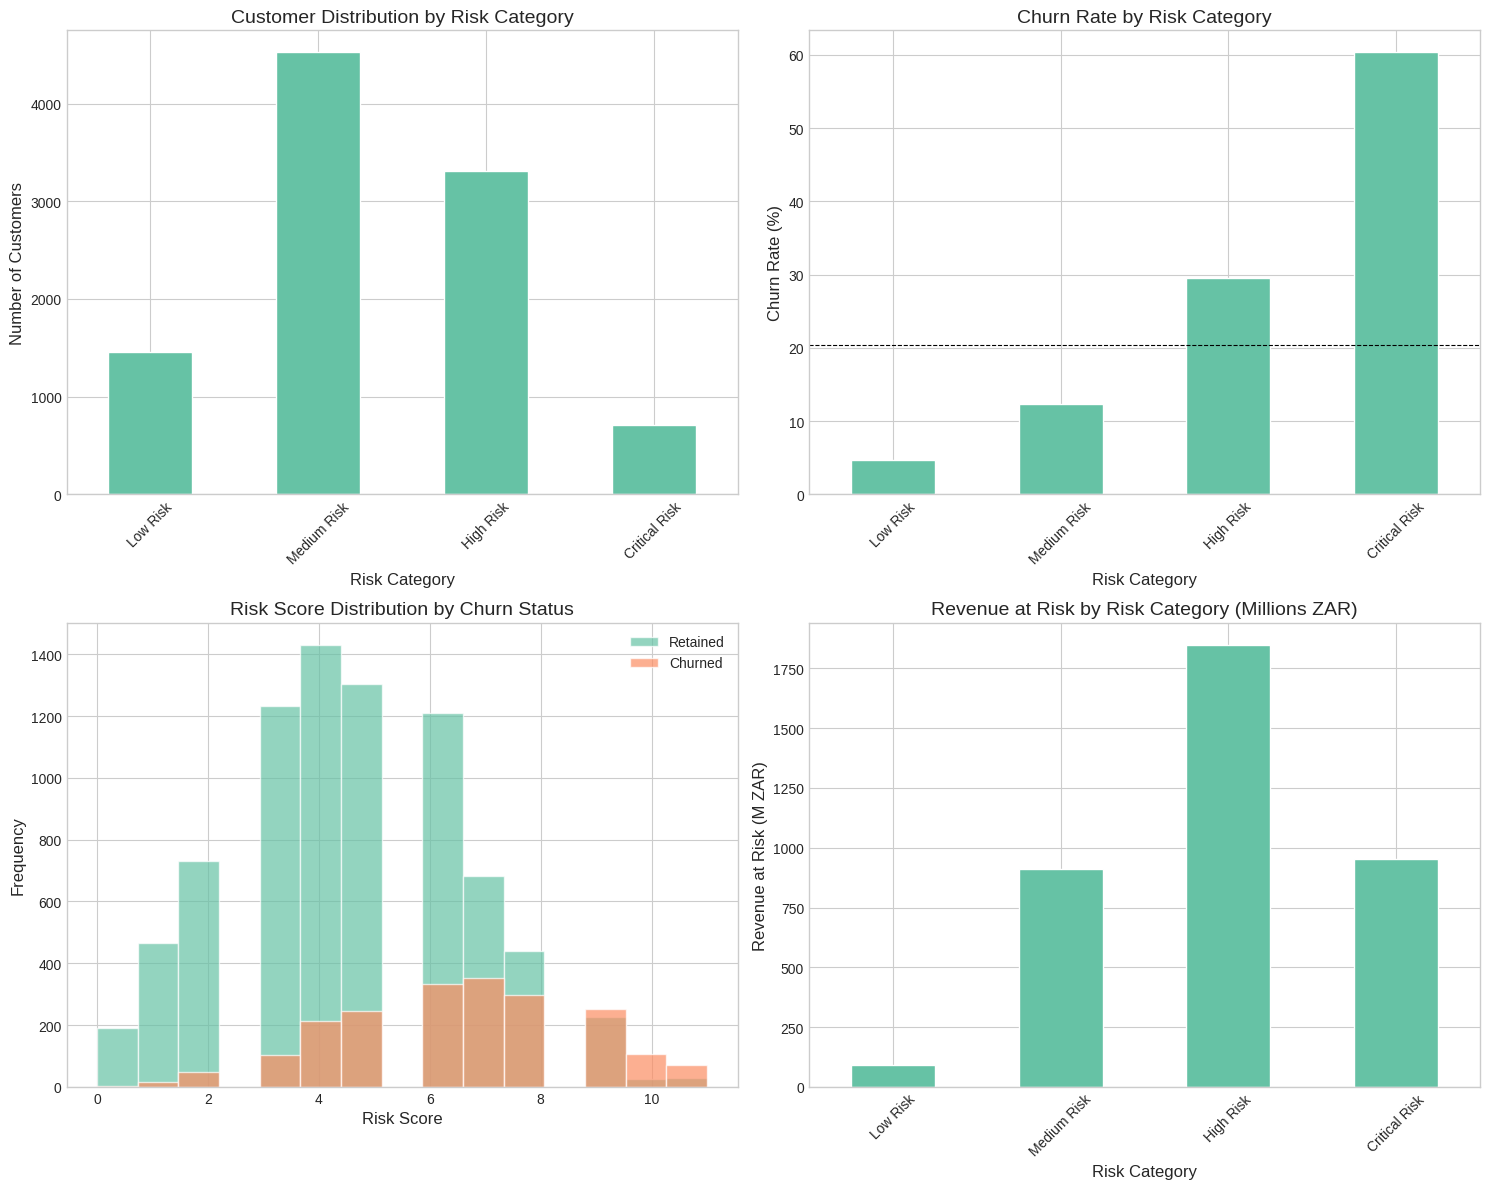

In [27]:
# SECTION C. Rule-Based Risk Profiling  # section label

print("\n" + "=" * 80)  # section header
print("SECTION C. RULE-BASED RISK PROFILING")  # section title
print("=" * 80)  # header underline

required_cols = ["Age", "NumOfProducts", "IsActiveMember", "Balance_ZAR", "Complaints_12M", "Churned"]  # minimum columns needed
missing_cols = [c for c in required_cols if c not in df.columns]  # check missing columns
if missing_cols:
    raise KeyError(f"Missing columns for Section C: {missing_cols}")  # stop early if dataset lacks fields

df = df.copy()  # protect upstream df from in-place edits

df["Risk_Score"] = 0  # initialise risk score

df.loc[df["Age"] >= 45, "Risk_Score"] += 3  # older customers higher churn exposure
df.loc[(df["Age"] >= 35) & (df["Age"] < 45), "Risk_Score"] += 1  # mid-age moderate exposure

df.loc[df["NumOfProducts"].isin([1, 4]), "Risk_Score"] += 2  # product extremes used as churn flags

df.loc[df["IsActiveMember"] == 0, "Risk_Score"] += 2  # inactive members tend to churn more

df.loc[df["Balance_ZAR"] > 2_000_000, "Risk_Score"] += 1  # high balances may indicate higher switching power

if "CreditRating" in df.columns:
    df.loc[df["CreditRating"].isin(["Poor", "Fair"]), "Risk_Score"] += 1  # weak credit bands add risk signal

df.loc[df["Complaints_12M"] > 0, "Risk_Score"] += 2  # complaints represent service friction

df["Risk_Category"] = pd.cut(  # map score to readable risk tiers
    df["Risk_Score"],
    bins=[-1, 2, 5, 8, 15],
    labels=["Low Risk", "Medium Risk", "High Risk", "Critical Risk"]
)

df["Revenue_at_Risk"] = df["Balance_ZAR"] * df["Churned"]  # balance exposed to churn

risk_analysis = df.groupby("Risk_Category").agg(  # summarise churn and exposure by risk bucket
    Count=("Churned", "count"),
    Churn_Rate=("Churned", "mean"),
    Churned_Count=("Churned", "sum"),
    Total_Balance=("Balance_ZAR", "sum"),
    Revenue_at_Risk=("Revenue_at_Risk", "sum")
)

risk_analysis["Churn_Rate_%"] = (risk_analysis["Churn_Rate"] * 100).round(2)  # churn rate as %
risk_analysis["Total_Balance_M"] = (risk_analysis["Total_Balance"] / 1_000_000).round(2)  # total balance in millions
risk_analysis["Revenue_at_Risk_M"] = (risk_analysis["Revenue_at_Risk"] / 1_000_000).round(2)  # churned balance in millions

print("\nRisk profile summary:")  # output label
print(risk_analysis[["Count", "Churn_Rate_%", "Churned_Count", "Total_Balance_M", "Revenue_at_Risk_M"]].to_string())  # display table

high_risk_mask = df["Risk_Category"].isin(["High Risk", "Critical Risk"])  # define high-risk set
precision = df.loc[high_risk_mask, "Churned"].mean()  # churn rate inside high-risk group
overall = df["Churned"].mean()  # baseline churn rate
lift = precision / overall if overall > 0 else np.nan  # lift vs baseline

print("\nRisk model lift:")  # lift block label
print(f"High/Critical risk churn rate: {precision:.1%}")  # churn rate in flagged group
print(f"Overall churn rate: {overall:.1%}")  # baseline churn rate
print(f"Lift: {lift:.2f}x")  # uplift from rule-based profiling

fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 plotting grid

df["Risk_Category"].value_counts().sort_index().plot(kind="bar", ax=axes[0, 0])  # customer distribution by risk tier
axes[0, 0].set_title("Customer Distribution by Risk Category")  # plot title
axes[0, 0].set_xlabel("Risk Category")  # x label
axes[0, 0].set_ylabel("Number of Customers")  # y label
axes[0, 0].tick_params(axis="x", rotation=45)  # rotate labels for readability

(df.groupby("Risk_Category")["Churned"].mean() * 100).plot(kind="bar", ax=axes[0, 1])  # churn rate by risk tier
axes[0, 1].set_title("Churn Rate by Risk Category")  # plot title
axes[0, 1].set_xlabel("Risk Category")  # x label
axes[0, 1].set_ylabel("Churn Rate (%)")  # y label
axes[0, 1].axhline(y=overall * 100, color="black", linestyle="--", linewidth=0.8)  # baseline churn reference
axes[0, 1].tick_params(axis="x", rotation=45)  # rotate labels for readability

axes[1, 0].hist(df.loc[df["Churned"] == 0, "Risk_Score"], bins=15, alpha=0.7, label="Retained")  # retained risk score distribution
axes[1, 0].hist(df.loc[df["Churned"] == 1, "Risk_Score"], bins=15, alpha=0.7, label="Churned")  # churned risk score distribution
axes[1, 0].set_title("Risk Score Distribution by Churn Status")  # plot title
axes[1, 0].set_xlabel("Risk Score")  # x label
axes[1, 0].set_ylabel("Frequency")  # y label
axes[1, 0].legend()  # legend for churn groups

(df.groupby("Risk_Category")["Revenue_at_Risk"].sum() / 1_000_000).plot(kind="bar", ax=axes[1, 1])  # balance at risk by category
axes[1, 1].set_title("Revenue at Risk by Risk Category (Millions ZAR)")  # plot title
axes[1, 1].set_xlabel("Risk Category")  # x label
axes[1, 1].set_ylabel("Revenue at Risk (M ZAR)")  # y label
axes[1, 1].tick_params(axis="x", rotation=45)  # rotate labels for readability

plt.tight_layout()  # improve spacing
plt.savefig("advanced_eda_risk_profiling.png", dpi=300, bbox_inches="tight")  # save plot for GitHub
print("\nSaved: advanced_eda_risk_profiling.png")  # confirmation message
plt.show()  # render plots

## Section D. Cohort Analysis by Tenure

This section groups customers into tenure cohorts to study how churn changes as relationships mature.

Outputs:
- Cohort sizes.
- Churn rate by cohort.
- Balance and product depth trends across cohorts.


COHORT ANALYSIS BY TENURE

Cohort summary:
               Count  Churn_Rate  Avg_Balance  Avg_Products  Avg_Credit  Churn_Rate_%
Tenure_Cohort                                                                        
0-1 years       1448        0.23 1,618,124.08          1.48      649.73         23.00
2-3 years       2057        0.20 1,583,542.79          1.56      651.70         20.00
4-5 years       2001        0.21 1,542,943.65          1.54      651.01         21.00
6-7 years       1995        0.19 1,537,404.36          1.52      648.53         19.00
8-10 years      2499        0.20 1,570,493.87          1.54      651.24         20.00

Saved: advanced_eda_cohort_analysis.png


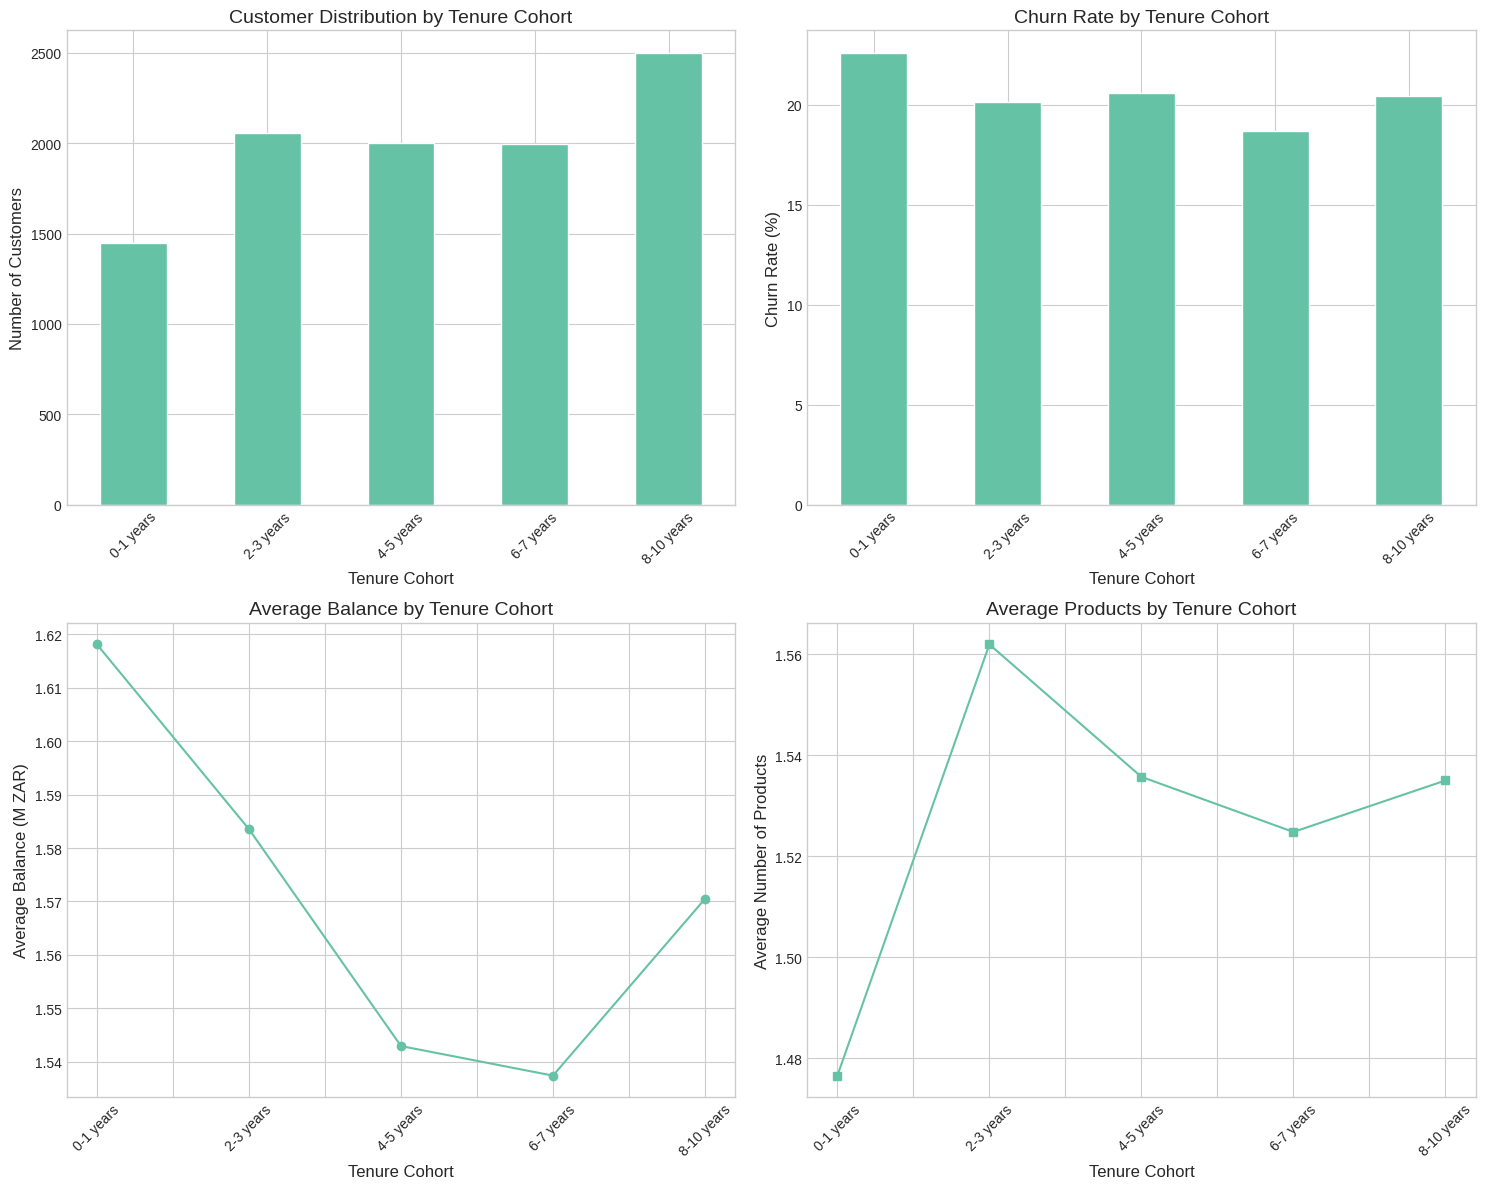

In [21]:
print("\n" + "=" * 80)                                                   # Section header
print("COHORT ANALYSIS BY TENURE")
print("=" * 80)

df["Tenure_Cohort"] = pd.cut(
    df["Tenure"],
    bins=[-1, 1, 3, 5, 7, 10],
    labels=["0-1 years", "2-3 years", "4-5 years", "6-7 years", "8-10 years"]
)                                                                          # Tenure cohorts for lifecycle comparisons

cohort_analysis = df.groupby("Tenure_Cohort").agg({
    "Churned": ["count", "mean"],
    "Balance_ZAR": "mean",
    "NumOfProducts": "mean",
    "CreditScore": "mean"
}).round(2)                                                                 # Cohort summaries
cohort_analysis.columns = ["Count", "Churn_Rate", "Avg_Balance", "Avg_Products", "Avg_Credit"]  # Flatten columns
cohort_analysis["Churn_Rate_%"] = (cohort_analysis["Churn_Rate"] * 100).round(2)              # Convert churn to %
print("\nCohort summary:")                                                # Table heading
print(cohort_analysis)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))                           # 2x2 grid

df["Tenure_Cohort"].value_counts().sort_index().plot(kind="bar", ax=axes[0, 0])  # Cohort size distribution
axes[0, 0].set_title("Customer Distribution by Tenure Cohort")
axes[0, 0].set_xlabel("Tenure Cohort")
axes[0, 0].set_ylabel("Number of Customers")
axes[0, 0].tick_params(axis="x", rotation=45)

(df.groupby("Tenure_Cohort")["Churned"].mean() * 100).plot(kind="bar", ax=axes[0, 1])          # Churn rate by cohort
axes[0, 1].set_title("Churn Rate by Tenure Cohort")
axes[0, 1].set_xlabel("Tenure Cohort")
axes[0, 1].set_ylabel("Churn Rate (%)")
axes[0, 1].tick_params(axis="x", rotation=45)

(df.groupby("Tenure_Cohort")["Balance_ZAR"].mean() / 1_000_000).plot(kind="line", marker="o", ax=axes[1, 0])  # Balance trend
axes[1, 0].set_title("Average Balance by Tenure Cohort")
axes[1, 0].set_xlabel("Tenure Cohort")
axes[1, 0].set_ylabel("Average Balance (M ZAR)")
axes[1, 0].tick_params(axis="x", rotation=45)

(df.groupby("Tenure_Cohort")["NumOfProducts"].mean()).plot(kind="line", marker="s", ax=axes[1, 1])             # Product depth trend
axes[1, 1].set_title("Average Products by Tenure Cohort")
axes[1, 1].set_xlabel("Tenure Cohort")
axes[1, 1].set_ylabel("Average Number of Products")
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig("advanced_eda_cohort_analysis.png", dpi=300, bbox_inches="tight")
print("\nSaved: advanced_eda_cohort_analysis.png")
plt.show()

## Section E. Customer Lifetime Value Proxy and Value at Risk

This section introduces a simple CLV proxy to quantify value exposure from churn.

Assumptions:
- A constant average annual revenue per customer (business placeholder).
- A small balance-based contribution representing interest margin.

Outputs:
- Average CLV for churned vs retained.
- Total CLV at risk.
- CLV at risk by segment and province.


CUSTOMER LIFETIME VALUE (CLV) PATTERNS

CLV summary:
Average CLV (all): R281,999.21
Average CLV (retained): R281,489.52
Average CLV (churned): R283,991.71
Total CLV at risk: R578,491,118.80

CLV by customer segment:
                  Avg_CLV  Total_CLV_at_Risk  Churned_Count
Customer_Value                                             
Low Value      108,871.26      32,204,361.92            263
Medium Value   256,489.04     280,807,141.36           1152
High Value     431,461.68     221,608,704.41            528
VIP            485,350.45      43,870,911.11             94

Saved: advanced_eda_clv_patterns.png


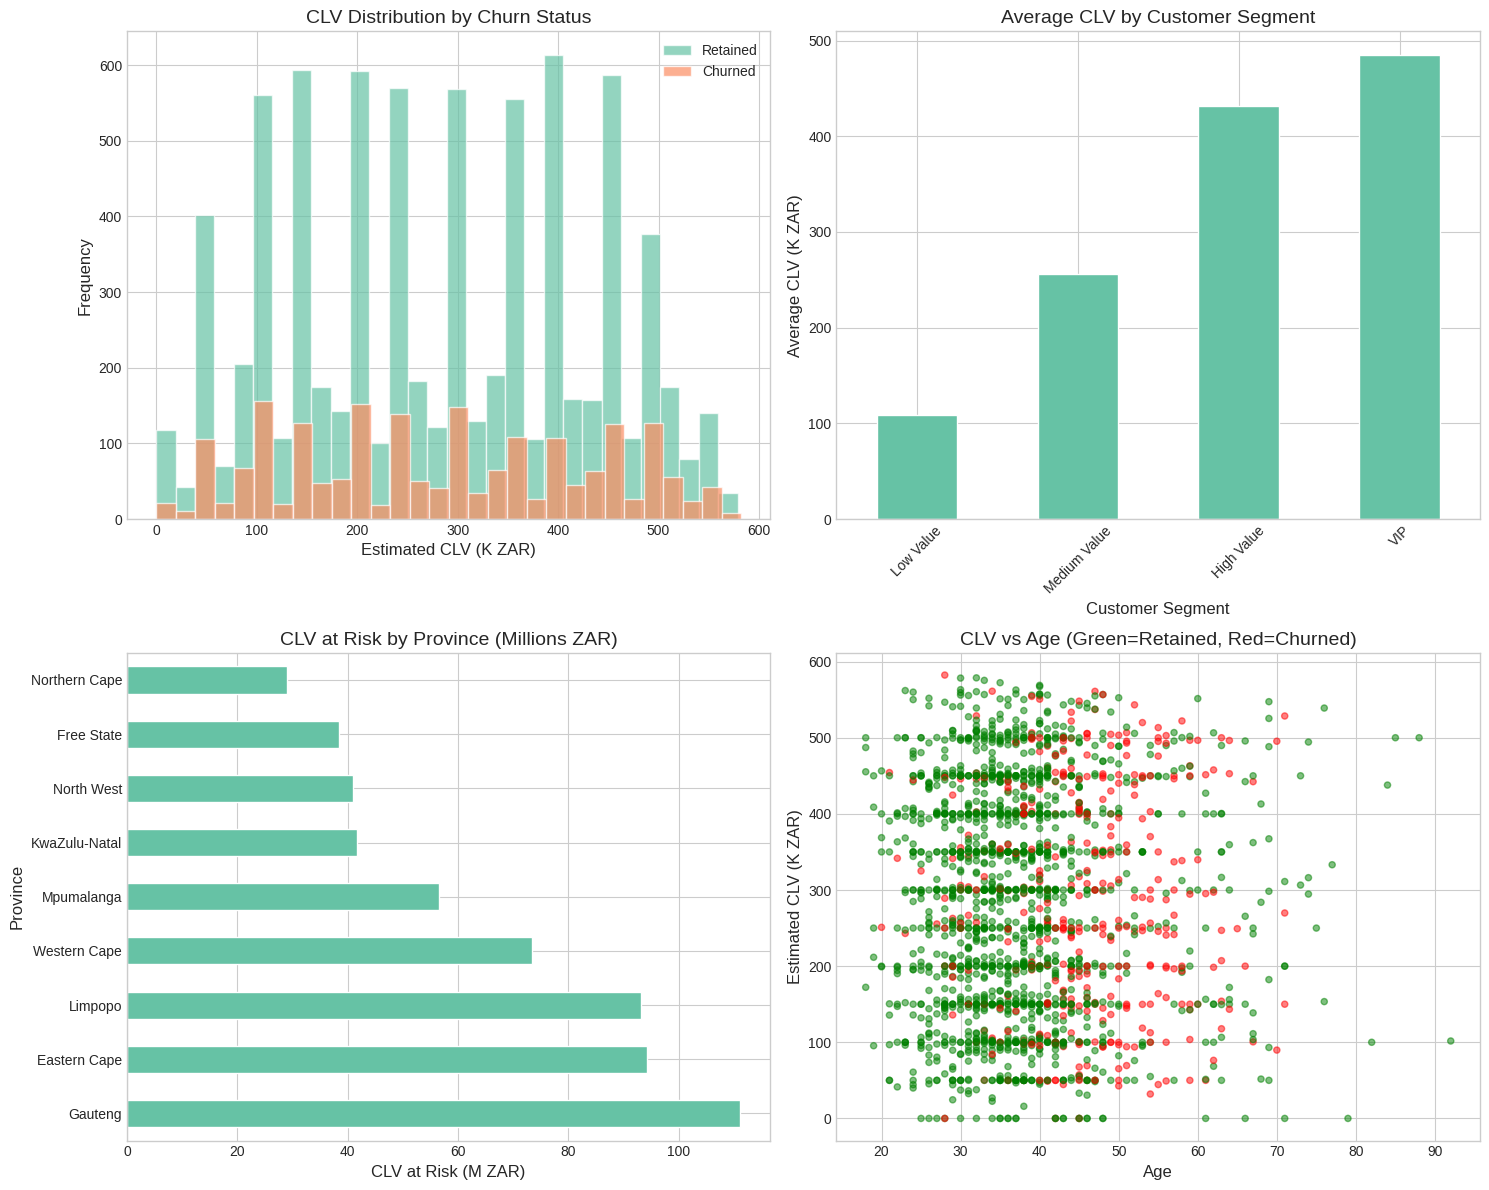

In [22]:
print("\n" + "=" * 80)                                                   # Section header
print("CUSTOMER LIFETIME VALUE (CLV) PATTERNS")
print("=" * 80)

avg_annual_revenue_per_customer = 50_000                                 # CLV revenue assumption (documented placeholder)

df["Estimated_CLV"] = (
    avg_annual_revenue_per_customer * df["Tenure"] +
    df["Balance_ZAR"] * 0.02
)                                                                          # Simplified CLV proxy

df["CLV_at_Risk"] = df["Estimated_CLV"] * df["Churned"]                   # CLV counted only for churned customers

print("\nCLV summary:")                                                   # Output summary header
print(f"Average CLV (all): R{df['Estimated_CLV'].mean():,.2f}")
print(f"Average CLV (retained): R{df.loc[df['Churned']==0, 'Estimated_CLV'].mean():,.2f}")
print(f"Average CLV (churned): R{df.loc[df['Churned']==1, 'Estimated_CLV'].mean():,.2f}")
print(f"Total CLV at risk: R{df['CLV_at_Risk'].sum():,.2f}")

if "Customer_Value" in df.columns:
    clv_by_segment = df.groupby("Customer_Value").agg({
        "Estimated_CLV": "mean",
        "CLV_at_Risk": "sum",
        "Churned": "sum"
    }).round(2)                                                            # Segment-level CLV and risk
    clv_by_segment.columns = ["Avg_CLV", "Total_CLV_at_Risk", "Churned_Count"]
    print("\nCLV by customer segment:")                                     # Segment-level output header
    print(clv_by_segment)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))                           # 2x2 grid

axes[0, 0].hist(df.loc[df["Churned"] == 0, "Estimated_CLV"] / 1000, bins=30, alpha=0.7, label="Retained")  # Retained CLV distribution
axes[0, 0].hist(df.loc[df["Churned"] == 1, "Estimated_CLV"] / 1000, bins=30, alpha=0.7, label="Churned")    # Churned CLV distribution
axes[0, 0].set_title("CLV Distribution by Churn Status")
axes[0, 0].set_xlabel("Estimated CLV (K ZAR)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].legend()

if "Customer_Value" in df.columns:
    (df.groupby("Customer_Value")["Estimated_CLV"].mean() / 1000).plot(kind="bar", ax=axes[0, 1])           # Avg CLV by segment
    axes[0, 1].set_title("Average CLV by Customer Segment")
    axes[0, 1].set_xlabel("Customer Segment")
    axes[0, 1].set_ylabel("Average CLV (K ZAR)")
    axes[0, 1].tick_params(axis="x", rotation=45)

(df.groupby("Province")["CLV_at_Risk"].sum() / 1_000_000).sort_values(ascending=False).plot(kind="barh", ax=axes[1, 0])  # CLV at risk by province
axes[1, 0].set_title("CLV at Risk by Province (Millions ZAR)")
axes[1, 0].set_xlabel("CLV at Risk (M ZAR)")
axes[1, 0].set_ylabel("Province")

sample = df.sample(min(2000, len(df)), random_state=42)                   # Sample for scatter readability
colors = sample["Churned"].map({0: "green", 1: "red"})                    # Colour by churn label
axes[1, 1].scatter(sample["Age"], sample["Estimated_CLV"] / 1000, c=colors, alpha=0.5, s=20)  # CLV vs age scatter
axes[1, 1].set_title("CLV vs Age (Green=Retained, Red=Churned)")
axes[1, 1].set_xlabel("Age")
axes[1, 1].set_ylabel("Estimated CLV (K ZAR)")

plt.tight_layout()
plt.savefig("advanced_eda_clv_patterns.png", dpi=300, bbox_inches="tight")
print("\nSaved: advanced_eda_clv_patterns.png")
plt.show()

## Section F. Statistical Significance and Effect Sizes

This section validates whether observed churn differences are statistically meaningful.

Tests:
- Independent t-tests for continuous variables.
- Chi-square tests for categorical variables.

Effect size:
- Cohen’s d to quantify practical magnitude beyond p-values.

In [23]:
print("\n" + "=" * 80)                                                   # Section header
print("STATISTICAL SIGNIFICANCE TESTS")
print("=" * 80)

churned = df[df["Churned"] == 1]                                          # Churned subset
retained = df[df["Churned"] == 0]                                         # Retained subset

continuous_vars = ["Age", "Tenure", "Balance_ZAR", "CreditScore", "AnnualSalary_ZAR", "FinancialWellnessScore"]  # Continuous candidates
t_results = []                                                           # Store t-test outputs

for var in continuous_vars:
    t_stat, p_value = stats.ttest_ind(churned[var], retained[var])        # Independent t-test
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"  # Significance marker
    t_results.append([var, round(t_stat, 3), float(f"{p_value:.4f}"), sig, round(churned[var].mean(), 2), round(retained[var].mean(), 2)])  # Collect stats

t_df = pd.DataFrame(t_results, columns=["Variable", "t-statistic", "p-value", "Significance", "Churned_Mean", "Retained_Mean"])  # Create results table
print("\nT-tests (continuous variables):")                                 # Output header
print(t_df.to_string(index=False))                                         # Print table

categorical_vars = ["Gender", "Province", "AccountType", "CreditRating", "EmploymentType"]  # Categorical candidates (single-bank scope)
chi_results = []                                                           # Store chi-square outputs

for var in categorical_vars:
    contingency = pd.crosstab(df[var], df["Churned"])                      # Contingency table
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)     # Chi-square test
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"  # Significance marker
    chi_results.append([var, round(chi2, 3), float(f"{p_value:.4f}"), sig])  # Collect stats

chi_df = pd.DataFrame(chi_results, columns=["Variable", "Chi2", "p-value", "Significance"])  # Create results table
print("\nChi-square tests (categorical variables):")                        # Output header
print(chi_df.to_string(index=False))                                       # Print table

effect_sizes = []                                                          # Store effect sizes
for var in continuous_vars:
    mean_diff = churned[var].mean() - retained[var].mean()                 # Mean difference
    pooled_std = np.sqrt((churned[var].std() ** 2 + retained[var].std() ** 2) / 2)  # Pooled standard deviation
    cohens_d = mean_diff / pooled_std if pooled_std > 0 else np.nan         # Cohen's d effect size
    magnitude = "Large" if abs(cohens_d) > 0.8 else "Medium" if abs(cohens_d) > 0.5 else "Small" if abs(cohens_d) > 0.2 else "Negligible"  # Magnitude label
    effect_sizes.append([var, round(cohens_d, 3), magnitude])               # Collect effect size

effect_df = pd.DataFrame(effect_sizes, columns=["Variable", "Cohen_d", "Magnitude"])  # Create effect size table
print("\nEffect sizes (Cohen's d):")                                        # Output header
print(effect_df.to_string(index=False))                                    # Print table


STATISTICAL SIGNIFICANCE TESTS

T-tests (continuous variables):
              Variable  t-statistic  p-value Significance  Churned_Mean  Retained_Mean
                   Age        29.77     0.00          ***         44.84          37.41
                Tenure        -1.40     0.16           ns          4.93           5.03
           Balance_ZAR        11.94     0.00          ***  1,867,725.06   1,491,278.58
           CreditScore        -2.71     0.01           **        645.35         651.85
      AnnualSalary_ZAR         1.21     0.23           ns  2,080,046.39   2,044,637.03
FinancialWellnessScore         6.99     0.00          ***          5.65           5.43

Chi-square tests (categorical variables):
      Variable   Chi2  p-value Significance
        Gender 112.92     0.00          ***
      Province 307.99     0.00          ***
   AccountType   2.41     0.66           ns
  CreditRating   8.94     0.06           ns
EmploymentType   2.63     0.62           ns

Effect sizes (Cohe

## Section G. Business Insights Brief

This section translates advanced EDA outputs into action-oriented observations.  
It does not claim causality. It frames potential retention opportunities and prioritisation.

The intent is to:
- Identify high-risk segments and high-value exposure.
- Highlight where service, product design, or engagement actions could reduce churn.
- Provide a baseline ROI thought experiment using transparent assumptions.

In [24]:
print("\n" + "=" * 80)                                                   # Section header
print("ACTIONABLE BUSINESS INSIGHTS")
print("=" * 80)

age_45_plus_churn = df[df["Age"] >= 45]["Churned"].mean()                 # Churn among 45+ customers
age_under_45_churn = df[df["Age"] < 45]["Churned"].mean()                # Churn among <45 customers

print("\n1) Age risk:")                                                   # Insight label
print(f"Churn rate (45+): {age_45_plus_churn:.1%}")                       # Print churn rate
print(f"Churn rate (<45): {age_under_45_churn:.1%}")                      # Print churn rate
print(f"Relative increase: {(age_45_plus_churn / age_under_45_churn - 1) * 100:.0f}%")  # Relative risk

product_churn = df.groupby("NumOfProducts")["Churned"].mean()             # Churn by product count
print("\n2) Product depth:")                                              # Insight label
print(product_churn.sort_index().apply(lambda x: f"{x:.1%}"))             # Display churn rates by product count

inactive_churn = df[df["IsActiveMember"] == 0]["Churned"].mean()          # Churn among inactive
active_churn = df[df["IsActiveMember"] == 1]["Churned"].mean()            # Churn among active

print("\n3) Activity status:")                                            # Insight label
print(f"Churn (inactive): {inactive_churn:.1%}")                          # Print churn
print(f"Churn (active): {active_churn:.1%}")                              # Print churn

total_clv_risk_m = df["CLV_at_Risk"].sum() / 1_000_000                     # Total CLV at risk in millions

print("\n4) Value exposure:")                                             # Insight label
print(f"Total CLV at risk: R{total_clv_risk_m:.2f}M")                      # Print exposure

if "Customer_Value" in df.columns:
    high_value_risk_m = df[df["Customer_Value"].isin(["High Value", "VIP"])]["CLV_at_Risk"].sum() / 1_000_000  # CLV risk in high segments
    share = (high_value_risk_m / total_clv_risk_m * 100) if total_clv_risk_m > 0 else np.nan                     # Share of total risk
    print(f"High-value CLV at risk: R{high_value_risk_m:.2f}M ({share:.1f}%)")                                   # Print concentration


ACTIONABLE BUSINESS INSIGHTS

1) Age risk:
Churn rate (45+): 44.6%
Churn rate (<45): 13.0%
Relative increase: 244%

2) Product depth:
NumOfProducts
1     27.7%
2      7.6%
3     82.7%
4    100.0%
Name: Churned, dtype: object

3) Activity status:
Churn (inactive): 26.9%
Churn (active): 14.3%

4) Value exposure:
Total CLV at risk: R578.49M
High-value CLV at risk: R265.48M (45.9%)
